# Init Tdx 

In [38]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

'module://ipympl.backend_nbagg'

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.08, '2025-05-30')

(11.57,
 59    2025-08-22
 Name: date, dtype: object)

9 0.09 0.84
Bull
0.84


### regression_line(X, Y)
regression_ratio(df, window=10):

9.85 0.02
Above
0.02


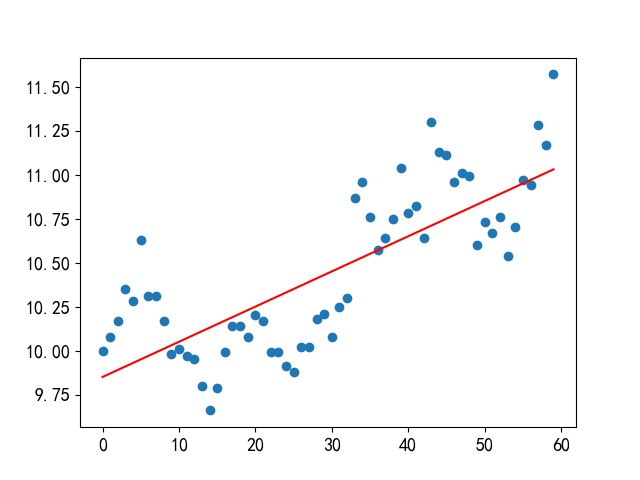

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.85 0.02
Above
0.02


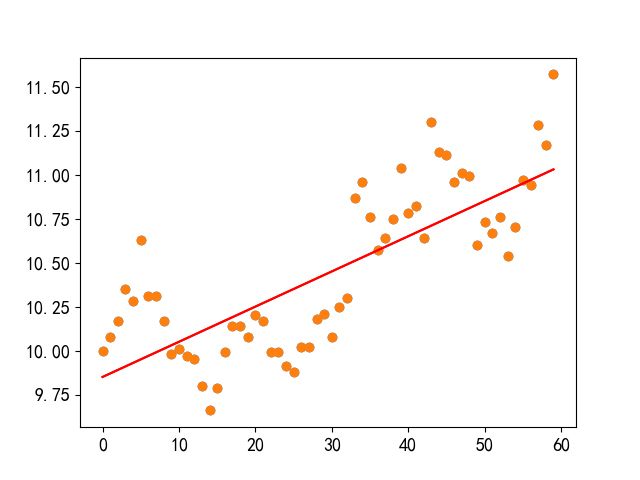

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max5', 'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60',
       'low4', 'lastdu4'],
      dtype='object', length=175)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close          vol        amount  \
59  2025-08-22  601360  11.19  11.58  11.12  11.57  225394518.0  2.573618e+09   

    lower   ene  ...  max10  hmax  hmax60  high4     llowvol  low10  low60  \
59   10.4  10.9  ...  11.28  11.3   10.63  11.28  66178500.0  10.54   9.66   

     low4   lastdu4  Positon  
59  10.75  3.963134  Neutral  

[1 rows x 176 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60', 'low4',
       'lastdu4', 'Positon'],
      dtype='object', length=176)

0    2025-05-30
1    2025-06-03
2    2025-06-04
Name: date, dtype: object

59   2025-08-22
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.02 
code: 601360


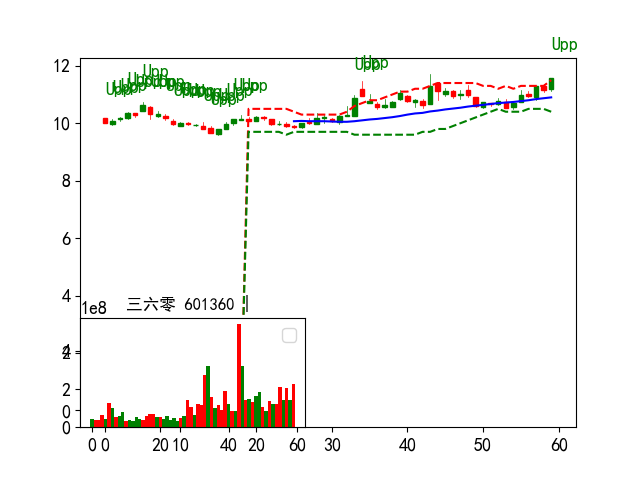

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)
buy
    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [150]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]
    df = df.query('close > 0')
    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5200
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close          vol  \
code   date                                                          
999999 2023-11-02  3028.00  3038.00  3010.00  3010.00  268794592.0   
       2023-11-03  3012.00  3040.00  3012.00  3030.00  268486336.0   
       2023-11-06  3048.00  3058.00  3038.00  3058.00  372949632.0   
       2023-11-07  3052.00  3064.00  3042.00  3058.00  326853440.0   
       2023-11-08  3052.00  3062.00  3038.00  3052.00  335677824.0   
...                    ...      ...      ...      ...          ...   
300507 2025-08-22     8.57     8.61     8.46     8.58   33460312.0   
300833 2025-08-22    36.84    36.97    36.59    36.84    1350439.0   
300127 2025-08-22    31.39    32.88    31.30    31.62   23452980.0   
300241 2025-08-22     6.56     6.72     6.38     6.63  100366952.0   
301567 2025-08-22    45.12    45.34    44.78    45.16    1321500.0   

                         amoun

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol       amount
date                                                         
2025-08-22  6.56  6.56  6.51   6.56  130769944.0  854125568.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50  15.50  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73  16.91  9484947.0  160420160.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-08-22',
 code
 688296    和达科技
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-08/22/25 16:37:43'

code
600007   2025-08-22 15:00:06
600287   2025-08-22 15:00:02
Name: ticktime, dtype: datetime64[ns]

97.68945455948511

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if len(store.keys()) > 0 and root is None and store is not None:
        root = store.keys()[0].replace("/", "")
        df = store[root]
        df = apply_col_toint(df)
    else:
        df = None
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
if h5 is not None:
    h5.shape
    h5code='603019'
    h5.loc[h5code][-3:]
    code_muti = '603019'
    # h5.loc[code_muti][:2]

    freq = 'D'
    # freq = '5M'
    startime = '09:25:00'
    endtime = '15:01:00'

    time_ratio = cct.get_work_time_ratio()
    time_ratio
    run_col = ['close', 'volume']
    # run_col = ['close']
    mdf = cct.get_limit_multiIndex_freq(
        h5, freq=freq.upper(),
        col=run_col, start=startime, end=endtime, code=None)
    allvol = mdf.volume.sum()
    allvol = round(allvol / 10 / 1000 / 1000,2)
    print("总量:%s 亿"%(allvol))
    mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
    mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
    #全局占比
    mdf['volume'] = mdf.amount.apply(
        lambda x: round(x / allvol * 100 / time_ratio, 2))
    mdf=mdf.reset_index().set_index('code')
    mdf.loc[h5code]
else:
    mdf = None

sina_MultiD_path:G:\sina_MultiIndex_data.h5
['/all_30']
G:\sina_MultiIndex_data.h5


(2821971, 6)

close   high    low  llastp     volume  lastbuy
ticktime                                                            
2025-08-22 14:59:41  82.81  82.81  76.62   75.31  129663938    76.62
2025-08-22 14:59:56  82.81  82.81  76.62   75.31  129663938    82.81
2025-08-22 15:00:03  82.81  82.81  76.62   75.31  129899538    82.81

1.0

总量:15450.12 亿


ticktime    2025-08-23 00:00:00
close                 82.208232
volume                     0.69
vol                       129.9
amount                   106.79
Name: 603019, dtype: object

In [30]:
if mdf is not None:
    mdf[:2]
    mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2025-08-23  12.033849    0.13  164.43   19.79
000002 2025-08-23   6.530497    0.06  130.77    8.54

ticktime    2025-08-23 00:00:00
close                 82.208232
volume                     0.69
vol                       129.9
amount                   106.79
Name: 603019, dtype: object

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
if h5 is not None:
    str(h5.index.get_level_values(1)[-1])[:10]

'2025-08-22'

In [32]:
if mdf is not None and len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-08-23 00:00:00
close                  6.530497
volume                     0.06
vol                      130.77
amount                     8.54
Name: 000002, dtype: object

###  实时成交量个股Top!!!  (重点)

In [33]:
if mdf is not None and len(mdf) > 0:
    nowdf = mdf.sort_values(by=['volume'], ascending=[0])
    # nowdf.shape, df.shape, code_idx.shape
    # top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd=get_sina_data_cname(top20_nd)
    # nowdf.shape,top20_nd
else:
    top20_nd = None

In [34]:
show_tdx_data(top20_nd).T
# top20_nd.columns

Count:20 2


code 300059 688981 000063 600111 688256 688041 300502 000977 603986 300803  \
name   东方财富   中芯国际   中兴通讯   北方稀土    寒武纪   海光信息    新易盛   浪潮信息   兆易创新    指南针   

code 601138 603019 300308 300418 300476 600410 002261 600030 002594 000617  
name   工业富联   中科曙光   中际旭创   昆仑万维   胜宏科技   华胜天成   拓维信息   中信证券    比亚迪   中油资本

### 合并实时成交量及SinaDM

In [43]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    # h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d':
    #     dl='60'
    # else:
    #     dl='200'
    # filter='y'
    # h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    # h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    # return h5
    h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d' or resample=='3d':
    #     dl='60'
    # elif  resample=='w':
    #     dl='200'
    # else:
    #     dl='300'
    if resample=='d' or resample=='3d':
        dl=ct.Resample_LABELS_Days[resample]
    elif  resample=='w':
        #200
        dl=ct.Resample_LABELS_Days[resample]
    else:
        #300
        dl=ct.Resample_LABELS_Days[resample]
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    if h5 is None:
        h5,tdx = tdd.get_append_lastp_to_df(sina_data.Sina().market('all'),dl=dl,resample=resample)
    return h5

In [36]:
# mdf[:1]
if mdf is not None and len(mdf) > 0:
    sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
else:
    sinadm = sina_dm

sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)


In [121]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_w_200_y_all']


In [125]:
if len(tdx_now_w) > 0 and tdx_now_w.lastp1d[-1] == tdx_now_w.close[-1]:
    query_sel = f'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'
else:
    query_sel = f'close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4'

In [127]:
tdx_now_w.query(f'{query_sel}')
query_sel

lopen  lhigh   llow  lastp         lvol       lamount   lower     ene  \
code                                                                            
000004   7.57   7.90   7.19   7.73   32441312.0  3.167162e+08    7.70    9.00   
000016   4.90   4.94   4.53   4.54  570333312.0  3.166218e+09    4.60    5.10   
000017   5.79   5.86   5.51   5.52  126152936.0  8.497092e+08    5.90    6.50   
000020  11.79  11.80   9.22  10.93   22050540.0  3.140470e+08   10.80   12.80   
000021  17.00  17.41  16.80  16.80  533725344.0  1.098508e+10   15.90   18.00   
...       ...    ...    ...    ...          ...           ...     ...     ...   
873726  21.14  21.41  20.30  20.31   38400064.0  1.715393e+09   22.30   30.20   
873806  12.84  13.24  12.01  12.69   56128640.0  9.339753e+08   14.00   15.50   
920002  46.28  51.47  43.38  47.06   13364940.0  1.782833e+09  105.62  140.38   
920088  22.94  24.28  21.62  22.16   25483952.0  1.043514e+09   18.80   34.31   
920445   7.25   7.72   6.90   7.09   24829768.0  2.863807e+08    9.20   10.40   

         upper  bandwidth  ...   close         nvol  lastbuy    nlow   nhigh  \
code                       ...                                                 
000004   10.40      29.66  ...   10.19    8766510.0    10.05    9.90   10.35   
000016    5.60      19.77  ...    5.56   67006218.0     5.54    5.52    5.59   
000017    7.10      18.48  ...    6.80   18999042.0     6.73    6.72    6.77   
000020   14.70      31.09  ...   14.36    3853110.0    14.34   14.40   14.51   
000021   20.09      23.56  ...   21.44  125142271.0    21.03   20.45   20.67   
...        ...        ...  ...     ...          ...      ...     ...     ...   
873726   38.09      52.50  ...   44.09    5977644.0    44.38   45.38   46.94   
873806   17.00      18.75  ...   16.78    9997742.0    16.77   16.61   16.91   
920002  175.25      49.56  ...  133.38    1758176.0   131.62  131.50  132.75   
920088   49.81      90.44  ...   41.56    5120825.0    41.56   41.72   43.38   
920445   11.50      22.55  ...   11.66    5252497.0    11.45   11.30   11.36   

        nclose  nstd     vol  amount  percent  
code                                           
000004   10.05  -2.0    8.77    0.88      0.3  
000016    5.54  -2.0   67.01    3.71      0.0  
000017    6.73  -2.0   19.00    1.28      0.6  
000020   14.34  -2.0    3.85    0.55     -0.3  
000021   21.03  -2.0  125.14   26.33      4.3  
...        ...   ...     ...     ...      ...  
873726   44.38  -2.0    5.98    2.65     -4.7  
873806   16.77  -2.0   10.00    1.68      0.2  
920002  131.62  -2.0    1.76    2.31      1.6  
920088   41.56  -2.0    5.12    2.13     -2.4  
920445   11.45  -2.0    5.25    0.60      3.5  

[1368 rows x 222 columns]

'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'

### tdx_last_df and Now sina!!! RealTIME

In [128]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_w_200_y_all']


In [152]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
if len(tdx_now) > 0 and tdx_now.lastp1d[-1] == tdx_now.close[-1]:
    tdx_select = tdx_now.query('close > lastp2d and percent > 3')
else:
    tdx_select = tdx_now.query('close > lastp1d and percent > 3')
show_tdx_data(tdx_select,limit=10)

(5190, 222)

Count:587 222


name  percent        date    close    hmax    lmin  perc1d   nclose  \
code                                                                          
300066  三川智慧     20.1  2025-06-03     8.44    7.23    5.70   49.69     8.41   
300192  科德教育     20.1  2025-06-20    21.59   17.84   14.26   39.50    21.59   
300418  昆仑万维     20.0  2025-06-20    44.38   37.12   33.00   38.69    42.53   
300767  震安科技     20.0  2025-05-30    25.34   21.30   12.49   44.69    22.75   
688709  成都华微     20.0  2025-07-10    47.03   35.81   30.89   38.19    42.09   
301377  鼎泰高科     20.0  2025-06-03    68.06   63.31   34.28   42.31    66.25   
688041  海光信息     20.0  2025-06-20   186.00  153.88  134.88   38.50   182.38   
688256   寒武纪     20.0  2025-07-10  1243.00  950.00  547.00   38.81  1187.00   
300113  顺网科技     20.0  2025-06-20    27.23   23.00   19.06   39.31    26.77   
688082  盛美上海     20.0  2025-05-30   142.25  126.25  109.75   32.31   137.75   

          llow  perc3d  perc5d  
code                            
300066    3.98    17.3   12.30  
300192   13.78     0.0    1.30  
300418   31.61     0.0   22.59  
300767   10.29     1.2   32.31  
688709   31.06    32.0    1.20  
301377   26.08    -0.1    1.20  
688041  133.50    25.8    1.20  
688256  520.50    12.6    1.30  
300113   17.41     0.0   24.09  
688082  101.12     0.0    1.30

In [148]:
tdx_filter.loc['000021']

lopen            17.02
lhigh            17.23
llow              16.8
lastp             16.8
lvol       125142272.0
              ...     
nclose           21.03
nstd              -2.0
vol             125.14
amount           26.33
percent            4.3
Name: 000021, Length: 222, dtype: object

In [165]:
print(f"buy is Na:{tdx_now.query('close.isna()').index.tolist()}")
# tdx_h5.loc['301397']
# tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("399") and not code.str.contains("999")')

show_tdx_data(tdx_filter)
# show_tdx_data(tdx_select,limit=10)

buy is Na:['399006', '399005', '399001', '999999', '000627', '300280', '300486', '300665', '301517', '601989', '603058', '603161', '603213', '688228', '688347']
Count:384 222


name  percent        date   close    hmax    lmin  perc1d  nclose  \
code                                                                        
300066  三川智慧     20.1  2025-06-03    8.44    7.23    5.70   49.69    8.41   
688227  品高股份     20.0  2025-06-20   39.44   34.25   28.27   32.31   38.50   
300113  顺网科技     20.0  2025-06-20   27.23   23.00   19.06   39.31   26.77   
300418  昆仑万维     20.0  2025-06-20   44.38   37.12   33.00   38.69   42.53   
688041  海光信息     20.0  2025-06-20  186.00  153.88  134.88   38.50  182.38   
300767  震安科技     20.0  2025-05-30   25.34   21.30   12.49   44.69   22.75   
688709  成都华微     20.0  2025-07-10   47.03   35.81   30.89   38.19   42.09   
301377  鼎泰高科     20.0  2025-06-03   68.06   63.31   34.28   42.31   66.25   
301259   艾布鲁     20.0  2025-07-30   51.62   49.19   37.62   34.31   48.75   
688343  云天励飞     19.9  2025-06-20   79.06   65.50   48.00   50.91   78.81   
300843  胜蓝股份     16.0  2025-05-30   56.62   52.00   30.50   35.31   52.75   
833509  同惠电子     15.9  2025-07-31   31.98   29.64   24.23   36.19   32.44   
836699   海达尔     14.8  2025-06-19   61.50   59.75   43.59   35.91   57.56   
688652  京仪装备     14.4  2025-06-17   80.00   65.50   53.00   46.09   76.00   
688981  中芯国际     14.2  2025-06-20  104.00   93.50   86.25   32.91   99.56   
688141   杰华特     13.6  2025-07-18   37.84   35.50   28.69   25.91   37.19   
688416  恒烁股份     13.3  2025-06-13   49.41   42.91   36.69   31.59   48.28   
688063  派能科技     12.3  2025-06-03   51.94   46.72   42.50   32.31   51.03   
300491  通合科技     12.3  2025-06-20   25.70   23.33   18.67    1.20   25.03   
688037   芯源微     11.6  2025-05-30  141.00  126.19  101.31   30.30  135.62   

          llow  perc3d  perc5d  
code                            
300066    3.98   17.30   12.30  
688227   28.11   -1.10   14.30  
300113   17.41    0.00   24.09  
300418   31.61    0.00   22.59  
688041  133.50   25.80    1.20  
300767   10.29    1.20   32.31  
688709   31.06   32.00    1.20  
301377   26.08   -0.10    1.20  
301259   37.72   -1.10   -0.90  
688343   46.28   19.30    0.20  
300843   26.23   -1.10   35.09  
833509   24.30    0.00   30.80  
836699   43.16   -1.10   44.31  
688652   51.12   18.41   15.60  
688981   81.25    0.00    1.20  
688141   28.69    0.00    1.20  
688416   36.47   21.30    1.30  
688063   41.53    0.00    0.10  
300491   16.91    0.10   25.20  
688037   91.25   27.70   17.50

#### 新高test!!!!!!

In [166]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [167]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5178, 45)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'nstd', 'vol', 'amount',
       'percent'],
      dtype='object')

name    open  llastp     now  trade    high     low     buy    sell  \
code                                                                          
688167  炬光科技  121.25  121.25  130.00    0.0  130.00  120.19  130.00  130.00   
300843  胜蓝股份   48.00   48.81   56.62    0.0   58.16   48.00   56.59   56.62   
002177  御银股份    9.44    9.09   10.00    0.0   10.00    9.35   10.00    0.00   
300269  联建光电    5.58    5.45    5.83    0.0    6.17    5.58    5.83    5.84   
301095   广立微   86.62   86.81   94.75    0.0   95.56   86.62   94.75   94.75   
...      ...     ...     ...     ...    ...     ...     ...     ...     ...   
688047  龙芯中科  136.12  134.00  143.88    0.0  145.62  135.75  143.75  143.88   
300491  通合科技   23.30   22.89   25.70    0.0   26.16   22.91   25.70   25.72   
688063  派能科技   47.69   46.25   51.94    0.0   53.00   47.31   51.94   51.94   
002544  普天科技   23.53   23.53   25.12    0.0   25.88   23.50   25.12   25.14   
430198  微创光电   11.52   11.28   12.15    0.0   12.95   11.44   12.15   12.16   

           volume  ...       nvol         timel  lastbuy    nlow   nhigh  \
code               ...                                                     
688167    7146482  ...    7146482  1.755849e+09   125.00  120.19  123.00   
300843   25982930  ...   25982930  1.755849e+09    52.75   48.00   51.50   
002177  235084397  ...  235084397  1.755849e+09     9.99    9.35   10.00   
300269  128012388  ...  128012388  1.755849e+09     5.85    5.58    5.83   
301095   15942751  ...   15942751  1.755849e+09    91.81   86.62   88.88   
...           ...  ...        ...           ...      ...     ...     ...   
688047   14078778  ...   14078778  1.755849e+09   142.25  135.75  137.38   
300491   38006222  ...   38006222  1.755849e+09    25.03   22.91   24.98   
688063   22006281  ...   22006281  1.755849e+09    51.03   47.31   49.22   
002544   60414393  ...   60414393  1.755849e+09    25.12   23.50   23.94   
430198   13375737  ...   13375737  1.755849e+09    12.23   11.44   11.80   

        nclose  nstd     vol  amount  percent  
code                                           
688167  125.00  -2.0    7.15    8.94      7.2  
300843   52.75  -2.0   25.98   13.71     16.0  
002177    9.99  -2.0  235.08   23.50     10.0  
300269    5.85  -2.0  128.01    7.49      7.0  
301095   91.81  -2.0   15.94   14.65      9.1  
...        ...   ...     ...     ...      ...  
688047  142.25  -2.0   14.08   20.02      7.4  
300491   25.03  -2.0   38.01    9.51     12.3  
688063   51.03  -2.0   22.01   11.23     12.3  
002544   25.12  -2.0   60.41   15.19      6.8  
430198   12.23  -2.0   13.38    1.64      7.7  

[213 rows x 45 columns]

## check HDF LastDate

In [168]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4910, 7)

(20, 7)

In [169]:
# df_tail1

In [170]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                   
689009 2024-12-26  45.12  46.09  44.88  45.09  6335058.0  288399168.0     1.05

In [171]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [172]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [173]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [174]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [175]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-08-21   8.86   8.89  8.84  8.77
2025-08-22   8.86   8.90  8.78  8.77

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-07-25  8.92  8.93  8.79    8.8  7449512.0  65776696.0     1.05  8.62   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-07-25  8.67  8.62  ...    2.44    1.97    0.92    1.97  86.29  -3.45   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-07-25  -1.52 -39.13  -8.76      33.4  

[1 rows x 28 columns]

(60, 28)


In [176]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff    hat   close  volsum5d    hmax    lmin  perc1d     ma20  \
date                                                                            
2025-08-21     1.03  48.56  1448.0     -37.5  1491.0  1414.0   -0.14  1432.50   
2025-08-22     1.04  52.58  1464.0       9.2  1465.0  1414.0    1.10  1432.95   

             ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d   ma51d  \
date                                                                            
2025-08-21  361.91 -32.56  -1.22  -2.12  -0.43  -1.14    1.40    1.47  1437.2   
2025-08-22  367.70  45.58 -32.56  -1.22  -2.12  -0.43    1.81    2.95  1445.6   

            ra_diff  
date                 
2025-08-21     1.03  
2025-08-22     1.04

### Append Now SinaTo MultiIndex dfNow

In [177]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-08-21  12.05  12.19  12.03  12.15  121741824.0  1.477053e+09   
       2025-08-22  12.15  12.17  11.98  12.06  164425984.0  1.979461e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-08-21     1.08  12.19  12.09  12.29  ...    0.58    0.58   -0.41   
       2025-08-22     1.07  12.16  12.08  12.27  ...    0.00   -0.17   -0.17   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-08-21  16.08  17.46 -27.94 -36.41  57.01      26.2  12.09  
       2025-08-22  35.06  16.08  17.46 -27.94 -36.41       4.2  12.08  

[2 rows x 29 columns]

In [178]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close          vol       amount  ra_diff  ma10  \
date                                                                           
2025-08-22  6.56  6.56  6.51   6.56  130769944.0  854125568.0     1.03  6.51   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-08-22  6.54  6.52  ...    0.46    0.92    0.46    1.0  -0.37 -19.99   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-08-22  17.56  -13.4     -15.2   6.54  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [179]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [180]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2025-04-28  62.09  63.34  62.09  62.19  19547744.0  1.224491e+09      1.0   

             ma10    ma5   ma20  ...  perc3d  perc4d  perc5d   vol1d  vol2d  \
date                             ...                                          
2025-04-28  14.41  19.73  11.82  ...  578.93  581.91  584.91  229.62  60.52   

            vol3d  vol4d  vol5d  volsum5d  ma51d  
date                                              
2025-04-28  34.07 -23.28  -26.6     274.3  19.73  

[1 rows x 29 columns]

## DFNow Query check

In [181]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-08-22


code    date      
399001  2025-08-22    48.23
399006  2025-08-22    15.97
300502  2025-08-22     4.06
301128  2025-08-22     2.02
300757  2025-08-22     1.99
300803  2025-08-22     1.85
301345  2025-08-22     1.63
603893  2025-08-22     1.47
300395  2025-08-22     1.34
002371  2025-08-22     1.17
Name: xratio, dtype: float64

date
2025-08-13     NaN
2025-08-14    0.05
2025-08-15    0.05
2025-08-18    0.05
2025-08-19    0.05
2025-08-20    0.05
2025-08-21    0.04
2025-08-22    0.03
Name: close, dtype: float64

In [182]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-08-21    5.85
2025-08-22    5.92
Name: upper, dtype: float64

(60, 29)
xratio:0.01 ra_diff:1.18
code: 300459


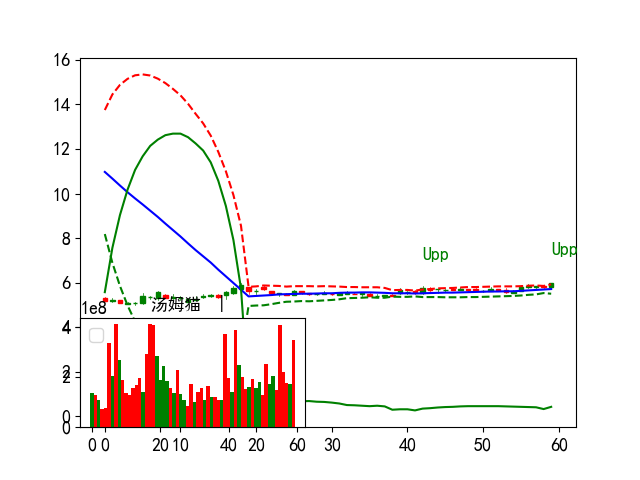

In [183]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [184]:
# '302132' in dfsRoot.index

300059
xratio:0.09 ra_diff:1.35
code: 300059


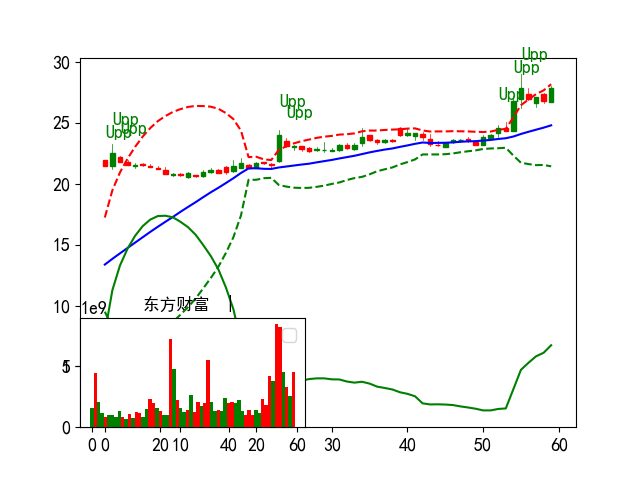

688981
xratio:0.16 ra_diff:1.27
code: 688981


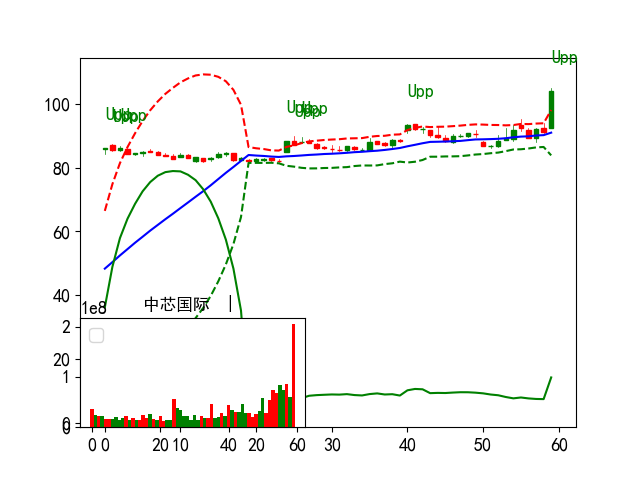

In [185]:
if top20_nd is not None:
    for co in top20_nd.index[:2]:
            print(co)
            # show_ohlc_upper(dfs.loc[co][-30:],co)
            if co in dfsRoot.index:
                show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
            else:
                print(f'code:{co} not find in dfsRoot')

In [186]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date    open    high      low   close          vol        amount  \
code                                                                            
999999 2025-08-22  3772.0  3826.0  3772.00  3826.0  698136256.0  1.095091e+12   
688981 2025-08-22    92.5   105.0    92.44   104.0  206194816.0  2.032297e+10   

        ra_diff     ma10     ma5  ...  perc5d   vol1d  vol2d  vol3d  vol4d  \
code                              ...                                        
999999     1.15  3718.00  3764.0  ...    3.52    0.95   1.72  -2.34 -10.30   
688981     1.27    91.24    93.8  ...   13.28  239.79 -29.34  15.32 -10.65   

        vol5d  volsum5d   ma51d  xratio     idx  
code                                             
999999  14.37       4.4  3764.0   10.96  178.00  
688981  20.70     235.8    93.8    0.20   17.31  

[2 rows x 32 columns]

In [187]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [188]:
df.loc['000002'][-2:]

open  high   low  close          vol       amount  ra_diff
date                                                                  
2025-08-21  6.55  6.59  6.53   6.56  129478432.0  850028800.0     1.03
2025-08-22  6.56  6.56  6.51   6.56  130769944.0  854125568.0     1.03

In [189]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol       amount  ra_diff  ma10  \
date                                                                           
2025-08-21  6.55  6.59  6.53   6.56  129478432.0  850028800.0     1.03  6.50   
2025-08-22  6.56  6.56  6.51   6.56  130769944.0  854125568.0     1.03  6.51   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2025-08-21  6.53  6.53  ...    2.02  -0.37 -19.99  17.56 -13.40  32.79   
2025-08-22  6.54  6.52  ...    0.46   1.00  -0.37 -19.99  17.56 -13.40   

            volsum5d  ma51d  xratio   idx  
date                                       
2025-08-21      16.6   6.53   -0.01  0.11  
2025-08-22     -15.2   6.54   -0.01  0.08  

[2 rows x 31 columns]

# 基础处理

In [190]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-07-15 2025-08-22


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-08-21  12.05  12.19  12.03  12.15  121741824.0  1.477053e+09   
       2025-08-22  12.15  12.17  11.98  12.06  164425984.0  1.979461e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-08-21     1.08  12.19  12.09  12.29  ...   -0.41  16.08  17.46   
       2025-08-22     1.07  12.16  12.08  12.27  ...   -0.17  35.06  16.08   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2025-08-21 -27.94 -36.41  57.01      26.2  12.09   -0.03 -0.25  
       2025-08-22  17.46 -27.94 -36.41       4.2  12.08   -0.02 -0.24  

[2 rows x 31 columns]

Low:2025-07-15


Timestamp('2025-07-16 00:00:00')

In [191]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(25421, 31)
count dd.couts
(code    date      
688798  2025-07-16    24
688386  2025-07-16    24
688383  2025-07-16    24
688326  2025-07-16    24
688003  2025-07-16    24
Name: couts, dtype: int64, (25421, 32))
dt_low:2025-07-15 df:1297 Index(['688798', '688386', '688383', '688326', '688003'], dtype='object', name='code') df_idx:2540
Main Down dd :0 MainUP df:1297 couts std:5.6 
time: 0.06  1201


In [192]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close          vol        amount  ra_diff  \
date                                                                        
2025-08-22  24.3  27.88  23.83   27.2  169143968.0  4.398529e+09     2.25   

             ma10    ma5   ma20  ...  perc5d  vol1d   vol2d  vol3d  vol4d  \
date                             ...                                        
2025-08-22  23.15  24.65  21.89  ...   13.24  16.85  134.44 -29.05 -26.63   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2025-08-22 -24.59      71.0  24.65    0.14  7.04  

[1 rows x 31 columns]

## 最近60天筛选

In [193]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [194]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)

(1809, 31)
count dd.couts
(code    date      
002983  2025-07-07    20
Name: couts, dtype: int64, (1809, 32))
(code    date      
002983  2025-08-19    20
601108  2025-08-14    19
Name: couts, dtype: int64, (421, 32))
Count:421 32


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
003040 2025-07-17      2     2.21    0.00  0.00  12.76  27.52     -25.7   
002826 2025-08-15      2     2.07    0.23  1.32   7.13  23.34     166.6   
688062 2025-08-21      6     2.04    0.13  3.31   5.61  36.62      -9.9   
002199 2025-08-04      5     1.82    0.00  0.00   1.55   9.48      55.3   
688553 2025-08-21      1     1.78    0.19  1.97   5.55  24.25       9.1   
300581 2025-08-22      7     1.74    0.12 -0.38   3.02  23.03     110.8   
000558 2025-07-30      1     1.70    0.00  0.00   2.25   6.59     381.0   
301137 2025-07-08      2     1.69    0.00  0.00  12.45  38.56     617.9   
300677 2025-08-22      1     1.69    0.40  0.50   8.96  38.09      -9.0   
301227 2025-08-04      6     1.68    0.00  0.00  11.18  29.30      60.4   
001298 2025-08-15      2     1.63    0.03  2.86   6.07  31.30     -87.6   
002161 2025-08-18      6     1.60    0.08  0.76   1.60   8.46      10.2   
688300 2025-08-22      1     1.59    0.30  6.44  10.06  60.53      62.6   
002961 2025-08-22      9     1.56    0.03  1.80   4.03  23.52     -78.1   
000668 2025-08-05      2     1.55    0.00  0.00   0.73   8.58     263.1   
002562 2025-08-21      1     1.53    0.05  0.80   2.48   6.80    -112.4   
301372 2025-07-31      1     1.50    0.00  0.00   9.82  30.41     436.0   
000576 2025-08-06      2     1.49    0.00  0.00   4.07  12.19      58.0   
688093 2025-08-20      5     1.48    0.36  1.79   9.67  37.38     -48.3   
688167 2025-08-14      1     1.47    1.19  0.00  37.60  96.88     -62.3   

                     hmax   lmin  perc1d   ma20  ma250  vol1d   vol2d   vol3d  \
code   date                                                                     
003040 2025-07-17   29.45  17.00   -1.89  26.94  25.58 -25.01   -8.95    7.50   
002826 2025-08-15   24.55  17.72   -0.68  21.37  21.58 -31.51  128.99  -39.87   
688062 2025-08-21   39.31  31.88   -0.19  35.11  35.16 -25.70  -14.79   22.08   
002199 2025-08-04    9.61   8.03    4.98   8.76   8.73  -0.65   58.29  -28.11   
688553 2025-08-21   26.59  20.55   -1.58  23.02  22.07 -40.59    4.37  -29.54   
300581 2025-08-22   25.77  20.48    0.39  22.73  21.80  34.84  -38.79   63.97   
000558 2025-07-30    6.59   4.35   10.02   6.11   6.28  -8.72   46.65  -11.82   
301137 2025-07-08   45.56  31.88   -3.21  37.89  36.66 -19.52  685.10  -10.89   
300677 2025-08-22   40.88  30.16    1.74  36.26  36.89   6.69   22.27  -38.74   
301227 2025-08-04   31.30  22.23    1.98  26.94  26.71  64.76  -35.73   -3.81   
001298 2025-08-15   33.91  28.05    1.26  30.20  30.31 -40.25  -16.52  -26.60   
002161 2025-08-18    8.99   6.97    0.36   7.92   7.73  -3.20  -27.81   33.71   
688300 2025-08-22   62.34  49.66    5.97  56.39  58.18  98.29    3.72   -1.01   
002961 2025-08-22   24.47  21.00    0.60  22.39  22.21 -28.60    2.50  -24.49   
000668 2025-08-05    8.58   7.67    5.02   8.11   7.93   8.71   76.17  -49.28   
002562 2025-08-21    7.79   5.46   -1.88   6.28   6.22 -40.09  -19.85  -34.97   
301372 2025-07-31   33.00  22.06    2.39  27.77  29.27 -35.05   46.97  183.06   
000576 2025-08-06   12.48   9.25   -0.08  11.73  11.75 -20.64   29.82    6.31   
688093 2025-08-20   40.22  29.83    2.16  34.81  34.76 -11.74  -15.54   31.90   
688167 2025-08-14  106.50  77.00   -3.30  89.25  89.22 -24.77   -7.87    1.49   

                    vol4d   vol5d  perc3d  perc5d  
code   date                                        
003040 2025-07-17    4.09   -3.33   11.42    8.52  
002826 2025-08-15   11.90   97.06    1.48   12.59  
688062 2025-08-21    0.07    8.46   -0.35    2.89  
002199 2025-08-04   19.31    6.46    7.12    6.16  
688553 2025-08-21  -30.09  104.98   -5.72    7.54  
300581 2025-08-22  -25.11   75.85    0.66    2.90  
000558 2025-07-30  393.09  -38.17   26.97   40.21  
301137 2025-07-08    8.13  -44.89    2.50   -0.90  
300677 2025-08-22   31.46  -30.70    2.78    0.98  
301227 2025-0

#### filter today

In [195]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [196]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [197]:
dfs.loc['301073'][-5:].ra_diff

date
2025-08-18    1.14
2025-08-19    1.14
2025-08-20    1.17
2025-08-21    1.19
2025-08-22    1.19
Name: ra_diff, dtype: float64

xratio:-0.0 ra_diff:1.03
code: 000002


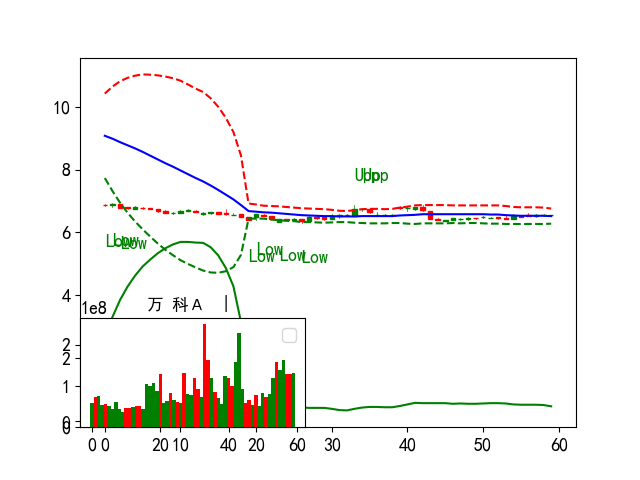

In [198]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [199]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [200]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-08-20    1.13
        2025-08-21    1.13
        2025-08-22    1.15
399001  2025-08-20    1.19
        2025-08-21    1.19
        2025-08-22    1.21
399006  2025-08-20    1.31
        2025-08-21    1.30
        2025-08-22    1.35
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [201]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d   hmax   lmin  perc1d  \
date                                                                            
2025-07-07     1.10     0.0  0.0  1.55  18.06     286.6  19.31  16.64   32.79   
2025-07-08     1.10     0.0  0.0  1.57  18.16     291.7  19.31  16.91    0.55   
2025-07-09     1.09     0.0  0.0  1.53  17.91     289.1  19.31  16.91   -1.38   
2025-07-10     1.08     0.0  0.0  1.50  17.80     300.6  19.31  16.91   -0.61   
2025-07-11     1.08     0.0  0.0  1.43  17.81     300.3  19.31  16.91    0.06   
2025-07-14     1.09     0.0  0.0  1.42  17.91     -72.4  19.31  16.91    0.56   
2025-07-16     1.05     0.0  0.0  1.44  17.33     -82.3  19.31  16.91   -3.24   
2025-07-17     1.06     0.0  0.0  1.45  17.48     -62.7  19.31  16.91    0.87   
2025-07-18     1.06     0.0  0.0  1.45  17.42     -53.8  19.31  16.91   -0.34   
2025-07-25     1.09     0.0  0.0  1.34  17.91      12.4  19.31  16.91    2.81   
2025-07-28     1.10     0.0  0.0  1.27  18.14      56.2  19.31  17.00    1.28   
2025-07-29     1.10     0.0  0.0  1.26  18.08      69.3  19.31  17.09   -0.33   
2025-07-30     1.11     0.0  0.0  1.23  18.17     167.5  19.31  17.19    0.50   
2025-07-31     1.11     0.0  0.0  1.23  18.17     170.6  19.31  17.19    0.00   
2025-08-01     1.09     0.0  0.0  1.17  17.91      97.4  19.31  17.19   -1.43   
2025-08-04     1.12     0.0  0.0  1.27  18.45      98.6  19.31  17.19    3.02   
2025-08-05     1.14     0.0  0.0  1.42  18.73     110.4  19.31  17.19    1.52   
2025-08-06     1.15     0.0  0.0  1.61  18.94       5.3  19.50  17.19    1.12   
2025-08-07     1.20     0.0  0.0  2.15  19.66     185.1  20.83  17.19    3.80   
2025-08-08     1.32     0.0  0.0  3.80  21.62     260.7  21.62  17.19    9.97   

             ma20  ma250   vol1d   vol2d   vol3d   vol4d   vol5d  perc3d  \
date                                                                       
2025-07-07  13.61  12.96  370.45  -21.42  -32.85  -14.89  -14.72   31.15   
2025-07-08  13.86  12.98   -9.63  370.45  -21.42  -32.85  -14.89   32.65   
2025-07-09  14.10  13.00  -17.46   -9.63  370.45  -21.42  -32.85   31.69   
2025-07-10  14.36  13.01  -21.37  -17.46   -9.63  370.45  -21.42   -1.44   
2025-07-11  14.62  13.03  -21.67  -21.37  -17.46   -9.63  370.45   -1.93   
2025-07-14  14.86  13.04   -2.24  -21.67  -21.37  -17.46   -9.63    0.00   
2025-07-16  15.07  13.05  -19.53   -2.24  -21.67  -21.37  -17.46   -2.64   
2025-07-17  15.28  13.06    2.12  -19.53   -2.24  -21.67  -21.37   -1.85   
2025-07-18  15.49  13.07  -12.50    2.12  -19.53   -2.24  -21.67   -2.74   
2025-07-25  15.71  13.09   44.52  -12.50    2.12  -19.53   -2.24    3.35   
2025-07-28  15.94  13.10   41.62   44.52  -12.50    2.12  -19.53    3.78   
2025-07-29  16.17  13.11   -6.44   41.62   44.52  -12.50    2.12    3.79   
2025-07-30  16.40  13.12  100.26   -6.44   41.62   44.52  -12.50    1.45   
2025-07-31  16.63  13.14   -9.41  100.26   -6.44   41.62   44.52    0.17   
2025-08-01  16.85  13.15  -28.65   -9.41  100.26   -6.44   41.62   -0.94   
2025-08-04  17.07  13.16   42.81  -28.65   -9.41  100.26   -6.44    1.54   
2025-08-05  17.33  13.17    5.36   42.81  -28.65   -9.41  100.26    3.08   
2025-08-06  17.58  13.19   -4.85    5.36   42.81  -28.65   -9.41    5.75   
2025-08-07  17.88  13.20  170.47   -4.85    5.36   42.81  -28.65    6.56   
2025-08-08  18.28  13.23   46.95  170.47   -4.85    5.36   42.81   15.43   

            perc5d  
date                
2025-07-07   29.37  
2025-07-08   33.33  
2025-07-09   30.07  
2025-07-10   30.02  
2025-07-11   30.96  
2025-07-14   -0.83  
2025-07-16   -4.57  
2025-07-17   -2.40  
2025-07-18   -2.13  
2025-07-25    0.56  
2025-07-28    1.28  
2025-07-29    4.33  
2025-07-30    3.95  
2025-07-31    4.31  
2025-08-01    0.00  
2025-08-04    1.71  
2025-08-05    3.60  
2025-08-06    4.24  
2025-08-07    8.20  
2025-08-08   20.71

## !!! Run-Filter强势Upper

### !!! filterRule test

In [202]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 0.02 0.22


'Bull'

0.22

date
2025-08-18   -0.01
2025-08-19   -0.01
2025-08-20   -0.01
2025-08-21   -0.01
2025-08-22   -0.00
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:1.04
code: 601728


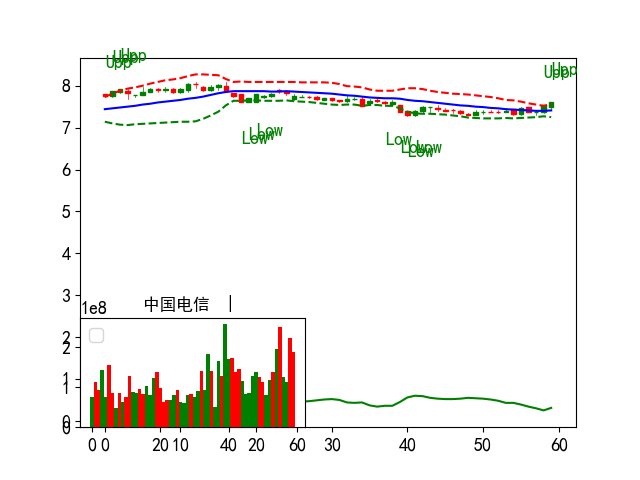

In [203]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [204]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:-0.04 ra_diff:1.0
code: 600012


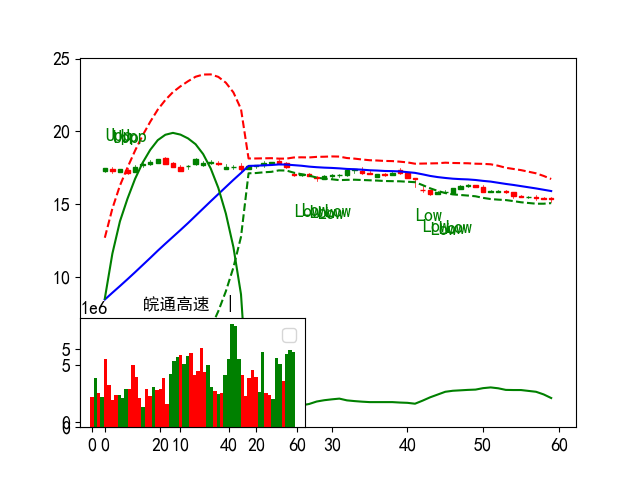

In [205]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [206]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 301489    20
 Name: couts, dtype: int64,
 (311, 41))

Count:311 41


name  couts       date   perc  ra_diff  xratio     idx      hat  \
code                                                                      
301489  思泉新材     20 2025-08-22  14.53     3.68    5.70   45.74   136.14   
399001   NaN     19 2025-08-22    NaN     1.21   48.23  880.00  1422.14   
002396  星网锐捷     18 2025-08-22   8.03     1.80    0.32    5.55     8.67   
603757  大元泵业     18 2025-08-22  -1.78     2.31    1.40   17.90    41.92   
002518   科士达     17 2025-08-22   1.43     1.65    0.52    9.98    17.15   
600498  烽火通信     17 2025-08-22   2.08     1.33    0.23    2.36     6.80   
300395   菲利华     16 2025-08-22   7.82     2.35    1.34   25.19    36.91   
999999   NaN     16 2025-08-22    NaN     1.15   10.96  178.00   286.42   
600183  生益科技     15 2025-08-22   7.16     1.87    0.33    7.53     8.82   
399006   NaN     14 2025-08-22    NaN     1.35   15.97  302.00   475.84   
301052  果麦文化     14 2025-08-22   5.40     2.30    1.12   12.74    27.57   
002859  洁美科技     14 2025-08-22   0.74     1.64    0.35    3.17     7.15   
300757  罗博特科     14 2025-08-22   5.63     1.70    1.99   57.75    70.31   
300502   新易盛     14 2025-08-22   6.21     3.14    4.06   80.87   129.66   
301345  涛涛车业     14 2025-08-22   5.20     3.03    1.63   29.75    42.48   
301387  光大同创     13 2025-08-22   5.02     1.31    0.30    5.59     9.10   
301280  珠城科技     13 2025-08-22   5.38     1.48    0.66    9.38    17.88   
301035  润丰股份     12 2025-08-22   5.08     1.36    0.36    5.88     8.10   
002718  友邦吊顶     12 2025-08-22   3.04     1.37    0.12    1.63     3.03   
002009  天奇股份     12 2025-08-22   2.39     1.25    0.10    0.57     2.91   

           close  volsum5d  ...    ma250  nclose      llow   vol1d   vol2d  \
code                        ...                                              
301489    193.12      24.4  ...    59.55  179.50    166.00   18.14    8.42   
399001  12168.00    5703.0  ...  3109.66     NaN  11904.00 -175.09 -273.18   
002396     34.03     168.6  ...    11.15   33.66     31.31   98.04   -3.55   
603757     50.09      41.4  ...    16.16   49.72     47.72  -19.43   29.56   
002518     35.50     215.4  ...    10.99   34.59     33.00  -26.32   27.81   
600498     26.56      80.9  ...    14.04   26.39     25.86   21.05   21.19   
300395    100.75      31.5  ...    27.47   99.56     92.31   70.90  -33.70   
999999   3826.00       4.4  ...     0.00     NaN   3772.00    0.95    1.72   
600183     47.62      -7.3  ...    15.27   47.28     43.75   48.66  -13.90   
399006   2682.00    1368.3  ...   540.31     NaN   2588.00  -16.77  -53.07   
301052     78.12     138.5  ...    26.73   76.44     71.56  -19.18  216.72   
002859     29.83      44.4  ...    16.93   29.69     29.20    3.33  -40.20   
300757    225.25      40.8  ...   103.61  223.50    212.00  -13.68   83.87   
300502    273.75      18.6  ...    50.50  269.75    254.25   15.84   -5.01   
301345    194.75      -5.7  ...    50.50  192.25    182.50   23.34   18.62   
301387     47.09     168.9  ...    35.05   46.50     44.53   27.24  -14.36   
301280     55.00      36.3  ...    34.65   53.47     51.62   92.91  -25.08   
301035     72.44     323.3  ...    32.02   73.69     70.19  295.02    8.24   
002718     19.66     148.4  ...    12.26   19.38     18.69   70.55   68.14   
002009     17.98     143.2  ...     9.84   17.84     17.45   48.58   -5.32   

         vol3d    vol4d   vol5d  perc3d  perc5d  
code                                             
301489   23.51   -23.09   -2.56    6.33   17.48  
399001 -100.84  6436.52 -184.39    2.91    4.61  
002396  -27.23   -37.93  139.29    9.77   17.43  
603757   -8.27   -15.32   54.84    7.35    6.30  
002518  185.56   -73.41  101.75    5.19   23.22  
600498  -15.98    -7.19   61.79    2.39    6.75  
300395    0.56     4.75  -10.98    5.92    1.45  
999999   -2.34   -10.30   14.37    2.63    3.52  
600183   -3.02   -44.29    5.24    6.63    6.20  
399006 -105.40  1729.54 -186.03    3.07    5.84  
301052  -14.31   -24.77  -20.00   17.81 

#### !!! hmax Top upper > 1

In [207]:
# dfs_tail9.loc['600103']

In [208]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
002168    13
Name: couts, dtype: int64 (439, 41)


(code
 002168    13
 Name: couts, dtype: int64,
 (439, 41))

Count:179 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
600739  辽宁成大     11 2025-08-22   3.30     1.27    0.05   1.24   1.59  13.13   
600183  生益科技      9 2025-08-22   7.16     1.87    0.33   7.53   8.82  47.62   
002625  光启技术      9 2025-08-22   2.01     1.29    0.40   4.50  11.48  49.16   
002657  中科金财      8 2025-08-22   6.96     2.45    0.59  16.28  24.75  47.16   
003019  宸展光电      8 2025-08-22   8.66     1.49    0.41  12.98  16.38  43.56   
300229   拓尔思      8 2025-08-22   4.02     1.62    0.21   1.74   4.48  27.69   
601778  晶科科技      8 2025-08-22  10.03     1.65    0.03   0.98   1.34   4.28   
002622  皓宸医疗      8 2025-08-22   9.92     1.56    0.05   0.97   1.55   4.21   
601878  浙商证券      8 2025-08-22   2.91     1.19    0.04   0.91   1.32  12.39   
600717   天津港      8 2025-08-22   3.75     1.16    0.02   0.33   0.67   5.25   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d   vol3d  vol4d  \
code              ...                                                        
600739      94.9  ...  10.50   12.83  12.62  157.70   -2.68  -29.15 -31.81   
600183      -7.3  ...  15.27   47.28  43.75   48.66  -13.90   -3.02 -44.29   
002625      17.9  ...  17.27   48.59  47.88  -25.97  -25.46    9.92  26.05   
002657      -5.7  ...  12.52   46.69  42.34   -3.06   -0.86   33.84 -24.27   
003019     201.3  ...  45.49   41.41  39.06   11.21  -15.96  244.40 -50.97   
300229      18.3  ...  11.54   27.30  26.34   14.62   20.88  -29.31  -1.95   
601778      19.2  ...  13.26    4.02   3.87   53.96    5.90  -28.95   8.06   
002622      22.6  ...  19.53    4.07   3.84   44.59   20.63    2.68 -14.96   
601878      14.2  ...  12.07   12.21  12.01   86.38  -18.77    5.11 -46.60   
600717     212.1  ...   7.34    5.16   5.02   29.83  150.11  -46.65  67.92   

        vol5d  perc3d  perc5d  
code                           
600739   0.80    4.12    5.38  
600183   5.24    6.63    6.20  
002625  33.32    9.17    9.39  
002657 -11.39   10.32   33.56  
003019  12.58   10.03   19.64  
300229  14.05    3.59    5.69  
601778 -19.72    7.81   19.55  
002622 -30.31   16.94    9.35  
601878 -11.88    3.51    2.14  
600717  10.94    4.79    6.92  

[10 rows x 24 columns]

In [209]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [210]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:351 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
300502    新易盛      7 2025-08-22   6.21     3.14     3.14    4.06  80.87   
300308   中际旭创      7 2025-08-22   5.18     3.09     3.09    4.21  64.25   
301345   涛涛车业      2 2025-08-22   5.20     3.03     3.03    1.63  29.75   
600475   华光环能      6 2025-08-22  10.02     2.67     2.67    0.49   3.04   
301377   鼎泰高科      6 2025-08-22  19.99     2.58     2.58    0.77  12.72   
002657   中科金财      8 2025-08-22   6.96     2.45     2.45    0.59  16.28   
300803    指南针      2 2025-08-22  10.24     2.45     2.45    1.85  50.13   
301052   果麦文化      5 2025-08-22   5.40     2.30     2.30    1.12  12.74   
002987    京北方      3 2025-08-22   7.34     2.25     2.25    0.14   7.04   
002177   御银股份      3 2025-08-22  10.01     2.18     2.18    0.08   3.53   
300843   胜蓝股份      5 2025-08-22  16.00     2.14     2.14    0.96  21.74   
600111   北方稀土      7 2025-08-22   7.51     2.07     2.07    0.49   9.28   
603657   春光科技      5 2025-08-22   7.16     2.07     2.07    0.44  13.59   
605303   园林股份      4 2025-08-22  10.04     2.03     2.03    0.15   7.05   
001298    好上好      2 2025-08-22  10.02     2.02     2.02    0.32   6.95   
600651   飞乐音响      7 2025-08-22   9.87     2.01     2.01    0.12   1.16   
300730   科创信息      5 2025-08-22   9.51     2.00     2.00    0.29   8.78   
002402    和而泰      6 2025-08-22   9.99     1.97     1.97    0.50   9.17   
603626   科森科技     10 2025-08-22  10.02     1.96     1.96    0.20   6.15   
002168  *ST惠程     13 2025-08-22   3.89     1.92     1.92    0.06   0.92   

           hat   close  ...  ma250  nclose    llow   vol1d   vol2d  vol3d  \
code                    ...                                                 
300502  129.66  273.75  ...  50.50  269.75  254.25   15.84   -5.01  -7.30   
300308  107.79  279.00  ...  44.33  273.25  259.00   -3.01   -3.37  -0.39   
301345   42.48  194.75  ...  50.50  192.25  182.50   23.34   18.62 -15.63   
600475   15.21   25.92  ...  10.23   25.89   24.28   -8.69    5.41 -25.41   
301377   18.63   68.06  ...  33.97   66.25   57.00   60.83   33.12  -4.30   
002657   24.75   47.16  ...  12.52   46.69   42.34   -3.06   -0.86  33.84   
300803   70.16  141.38  ...  38.41  137.00  127.19   -2.27   31.88 -27.04   
301052   27.57   78.12  ...  26.73   76.44   71.56  -19.18  216.72 -14.31   
002987    8.28   27.20  ...  32.01   26.09   23.83   16.85  134.44 -29.05   
002177    3.99   10.00  ...  18.52    9.99    9.35  867.34  -89.72   7.98   
300843   33.37   56.62  ...  27.99   52.75   48.00   35.34   27.54 -29.13   
600111   13.69   47.94  ...  20.09   47.56   44.56   22.65  -10.46 -24.79   
603657   18.95   44.47  ...  23.89   44.00   41.47    0.78  -11.96  91.03   
605303    8.56   20.05  ...  26.60   20.05   20.05  -85.14  -32.58  45.89   
001298   11.67   38.75  ...  29.10   38.06   35.31   -3.51   15.66 -39.25   
600651    2.80    7.90  ...   4.25    7.80    7.13   19.13    3.65  48.52   
300730   11.66   23.72  ...  19.13   23.72   20.17   -5.22   58.35 -30.08   
002402   13.16   36.12  ...  13.01   35.97   33.84   39.85   -7.18  21.76   
603626    7.72   15.26  ...  16.82   15.23   13.89  129.57  495.61 -91.52   
002168    1.91    5.08  ...   7.25    5.01    4.90   -1.85   -8.87  54.52   

          vol4d   vol5d  perc3d  perc5d  
code                                     
300502    -9.59   24.61    6.62   17.36  
300308   -12.78   34.04    1.27   17.23  
301345    -3.81  -28.21    9.56   15.92  
600475    24.90  -24.31   25.04   19.50  
301377   -21.98   25.03   12.79    8.51  
002657   -24.27  -11.39   10.32   33.56  
300803   -34.19   23.47   11.71   28.67  
301052   -24.77  -20.00   17.81   24.81  
002987   -26.63  -24.59   13.90   13.24  
002177   106.68  -20.95   33.16   46.20  
300843   -24.19    2.27   14.82   26.07  
600111    66.62   20.66    7.88   22.92  
603657    -9.11   -3.92   14.94   32.27  
605303    80.98  136.80   33.22  

xratio:-0.09 ra_diff:1.1
code: 300540


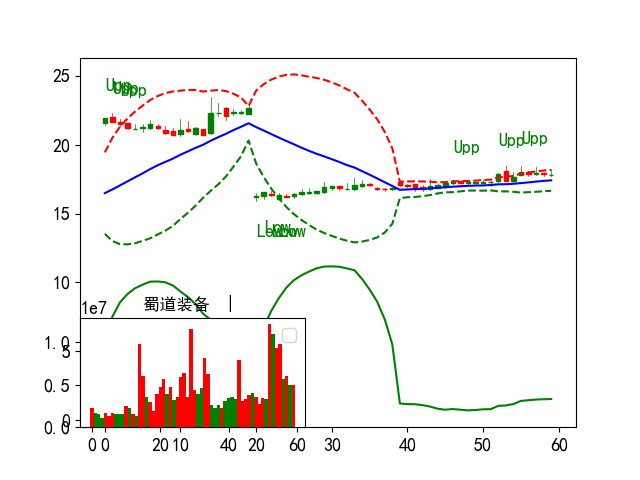

In [211]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [212]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(1434, 31)

count dd.couts
(code    date      
688372  2025-08-15    6
        2025-08-18    6
        2025-08-19    6
Name: couts, dtype: int64, (1058, 32))
compute percent
df_mask250:530 df_mask_hmax:439
cross_hamx:123
Count:63 41


name  couts       date   perc  ra_diff  xratio    idx     hat   close  \
code                                                                            
300502   新易盛      2 2025-08-19   6.21     2.94    4.11  70.63  101.83  273.75   
002371  北方华创      2 2025-08-22   6.23     1.20    1.17  56.75   54.88  383.50   
300803   指南针      3 2025-08-22  10.24     2.45    1.85  50.13   70.16  141.38   
603986  兆易创新      3 2025-08-22  10.04     1.34    0.67  32.94   32.15  150.88   
301345  涛涛车业      2 2025-08-22   5.20     3.03    1.63  29.75   42.48  194.75   
300843  胜蓝股份      3 2025-08-22  16.00     2.14    0.96  21.74   33.37   56.62   
603501  豪威集团      2 2025-08-22   5.39     1.15    0.25  17.00   17.89  136.88   
002657  中科金财      4 2025-08-20   6.96     2.33    0.33  15.27   18.77   47.16   
301269  华大九天      3 2025-08-22   5.03     1.15    0.43  15.26   17.24  125.38   
000063  中兴通讯      2 2025-08-22   9.40     1.50    0.31  12.56   13.50   46.56   
603657  春光科技      3 2025-08-20   7.16     1.97    0.25  12.24   13.26   44.47   
300844  山水比德      4 2025-08-21   1.69     1.31    0.47  12.22   18.33   56.69   
601689  拓普集团      4 2025-08-22   5.13     1.36    0.31  12.12   15.12   58.81   
002190  成飞集成      3 2025-08-22  10.01     1.81    0.31  11.40   14.24   48.78   
301369  联动科技      2 2025-08-22   7.55     1.54    0.60  10.13   15.99   72.19   
002518   科士达      4 2025-08-22   1.43     1.65    0.52   9.98   17.15   35.50   
603031  安孚科技      3 2025-08-22  10.07     1.51    0.47   9.84   16.22   39.56   
301219  腾远钴业      3 2025-08-22   3.06     1.54    0.50   9.56   14.53   67.44   
300442  润泽科技      2 2025-08-22   5.55     1.38    0.24   9.34   14.19   59.34   
605376  博迁新材      3 2025-08-22   5.20     1.58    0.30   9.03   11.32   50.56   

        volsum5d  ...  ma250  nclose    llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                          
300502      -5.0  ...  47.45  269.75  241.50   -9.59   24.61  -10.96  -25.18   
002371     121.7  ...  96.75  380.25  360.50   18.96   69.59   38.15  -22.40   
300803      -8.1  ...  38.41  137.00  127.19   -2.27   31.88  -27.04  -34.19   
603986     194.6  ...  41.09  144.12  135.12   -9.10  138.67   11.36   -1.62   
301345      -5.7  ...  50.50  192.25  182.50   23.34   18.62  -15.63   -3.81   
300843      11.8  ...  27.99   52.75   48.00   35.34   27.54  -29.13  -24.19   
603501     169.8  ...  45.67  134.62  130.12   45.95   13.32   12.20  -42.93   
002657     173.4  ...  12.24   46.69   41.25   33.84  -24.27  -11.39  177.67   
301269     134.6  ...  54.42  124.00  119.88   34.55  -26.56   84.41  -28.02   
000063     441.2  ...  15.30   45.22   42.50  -13.11   51.09   60.41  -45.41   
603657      74.4  ...  23.78   44.00   39.53   91.03   -9.11   -3.92    1.99   
300844      -9.7  ...  24.39   57.41   53.81   48.14   -6.36  -29.02  -22.39   
601689      46.6  ...  22.48   58.22   56.00  -17.66    4.78  -31.53   96.07   
002190     280.3  ...  19.38   48.06   43.34  108.03  -29.33  136.85   23.57   
301369     162.2  ...  29.49   70.12   65.75    3.17   96.21   13.07  -40.80   
002518     215.4  ...  10.99   34.59   33.00  -26.32   27.81  185.56  -73.41   
603031      -4.1  ...  17.74   39.19   36.00   78.39    1.29  -26.05  -55.48   
301219      71.7  ...  44.84   67.94   66.75    9.31  -26.08   65.78  -12.54   
300442      70.8  ...  23.45   58.88   56.31   59.28    3.66   -6.37  -36.70   
605376     100.6  ...  20.57   50.38   49.50    9.30    7.57   40.17   43.76   

         vol5d  perc3d  perc5d  
code                            
300502   16.08   11.15   25.32  
002371   17.43   12.79   12.13  
300803   23.47   11.71   28.67  
603986   55.32   22.42   22.79  
301345  -28.21    9.56   15.92  
300843    2.27   14.82   26.07  
603501  141.29    8.85   10.61  
002657   -2.41   26.65   44.17  
301269   70.22    9.39   10.41  
000063  388.18   23.14   32.20  
603657   -5.56   25.58   32.27  
300844   -0.12    4.87   16.53  
60

df_mask250:176
300870 2.66
xratio:1.89 ra_diff:2.66
code: 300870


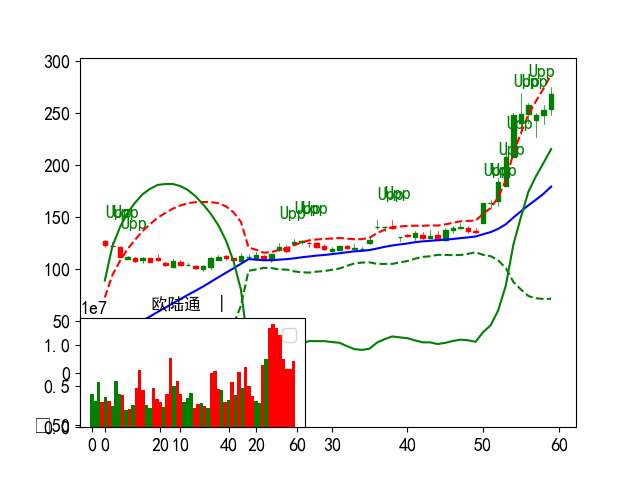

300502 3.14
xratio:2.59 ra_diff:3.14
code: 300502


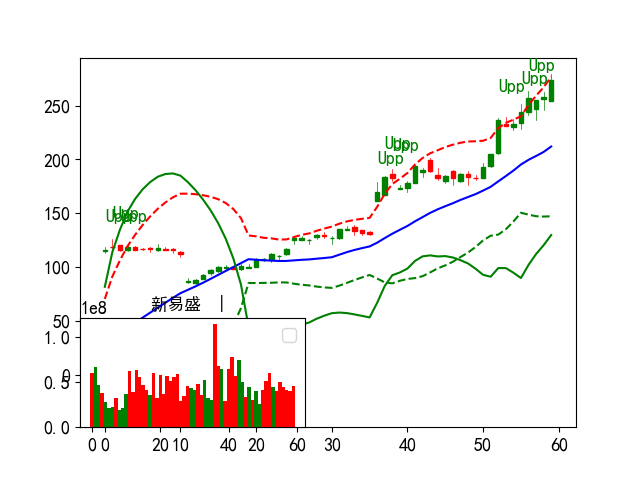

002371 1.2
xratio:-2.15 ra_diff:1.2
code: 002371


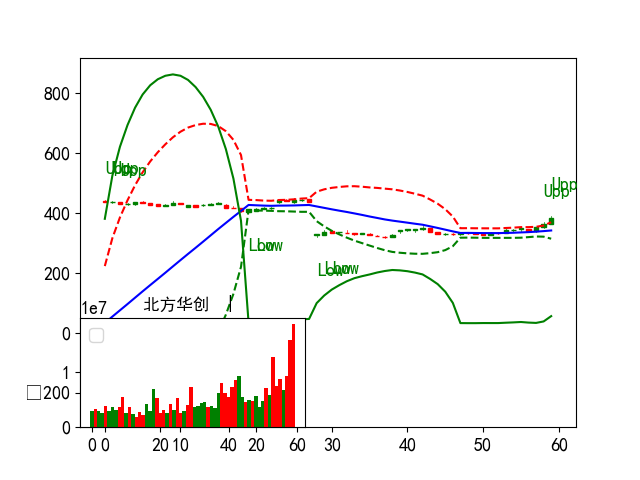

300803 2.45
xratio:1.04 ra_diff:2.45
code: 300803


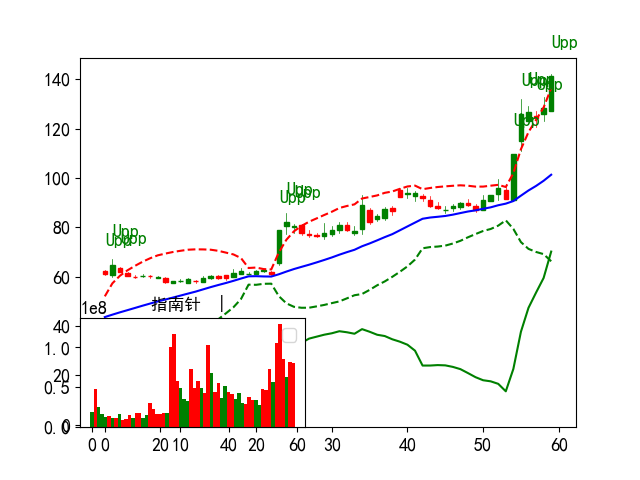

300620 2.26
xratio:0.67 ra_diff:2.26
code: 300620


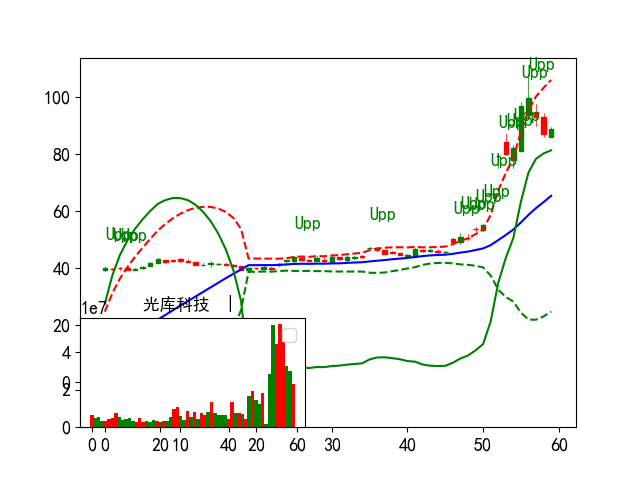

301128 2.18
xratio:0.31 ra_diff:2.18
code: 301128


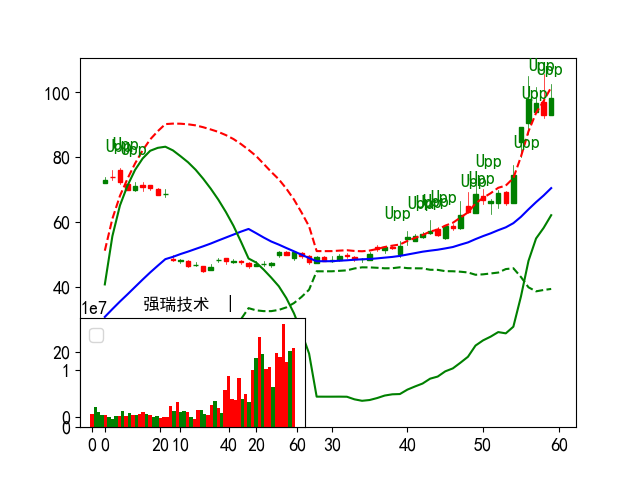

603986 1.34
xratio:0.09 ra_diff:1.34
code: 603986


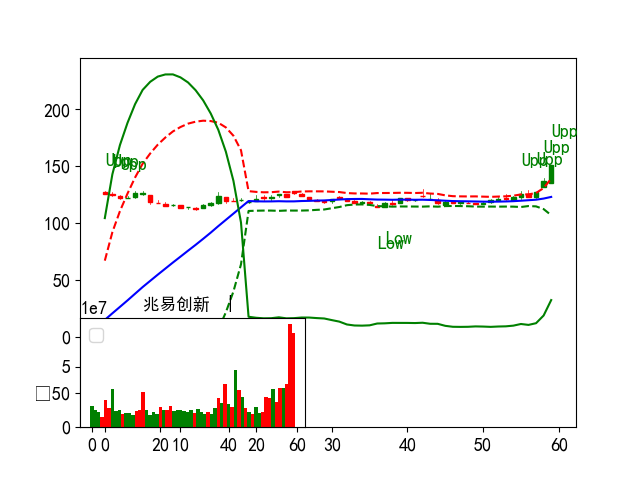

301413 1.62
xratio:0.28 ra_diff:1.62
code: 301413


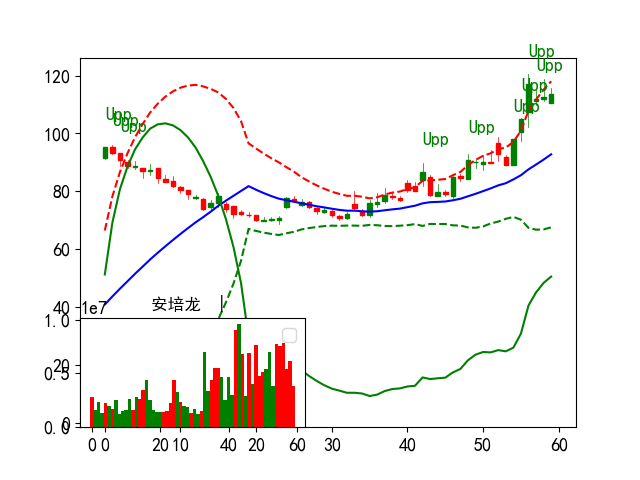

301345 3.03
xratio:2.33 ra_diff:3.03
code: 301345


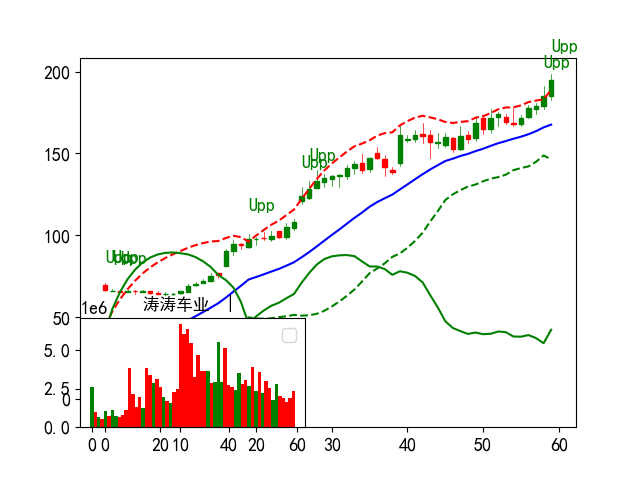

002837 2.71
xratio:0.53 ra_diff:2.71
code: 002837


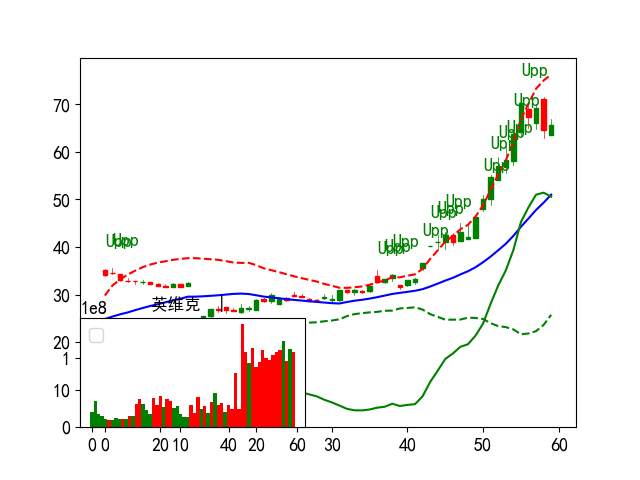

In [213]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [214]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date    lopen    lhigh     llow    close           vol  \
code                                                                  
399001 2025-08-22  11904.0  12168.0  11904.0  12168.0 -1.028743e+09   
399006 2025-08-19   2596.0   2634.0   2586.0   2602.0  3.243630e+10   

              amount  ra_diff     ma10      ma5  ...    idx  couts  nclose  \
code                                             ...                         
399001  1.451618e+12     1.21  11694.4  11934.4  ...  880.0      2     NaN   
399006  7.553139e+11     1.31   2453.2   2541.6  ...  244.0      2     NaN   

        name  open  high  low  llastp  ticktime  perc  
code                                                   
399001   NaN   NaN   NaN  NaN     NaN       NaT   NaN  
399006   NaN   NaN   NaN  NaN     NaN       NaT   NaN  

[2 rows x 41 columns]

(304, 41)

In [215]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])
if df_masklastd is not None and len(df_masklastd) > 0:

    code_t = '300675'
    code_t = '605268'
    code_t = '002828'
    code_t = '300418'
    code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(530, 41)  lastd:(112, 41) 
code
605028    世茂能源
002190    成飞集成
000063    中兴通讯
301259     艾布鲁
603986    兆易创新
300113    顺网科技
300767    震安科技
301108    洁雅股份
300730    科创信息
600490    鹏欣资源
301052    果麦文化
600315    上海家化
002402     和而泰
300478    杭州高新
301369    联动科技
002207    准油股份
600637    东方明珠
600962    国投中鲁
002674    兴业科技
300843    胜蓝股份
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:439
002168 1.92
xratio:0.03 ra_diff:1.92
code: 002168


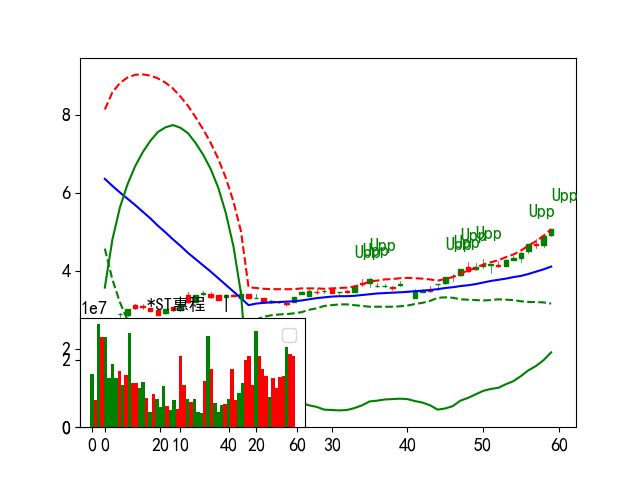

399001 1.21
xratio:30.74 ra_diff:1.21
code: 399001


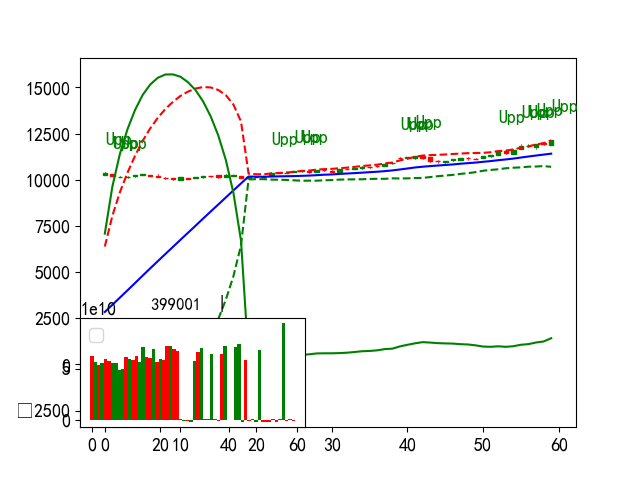

300757 1.7
xratio:1.26 ra_diff:1.7
code: 300757


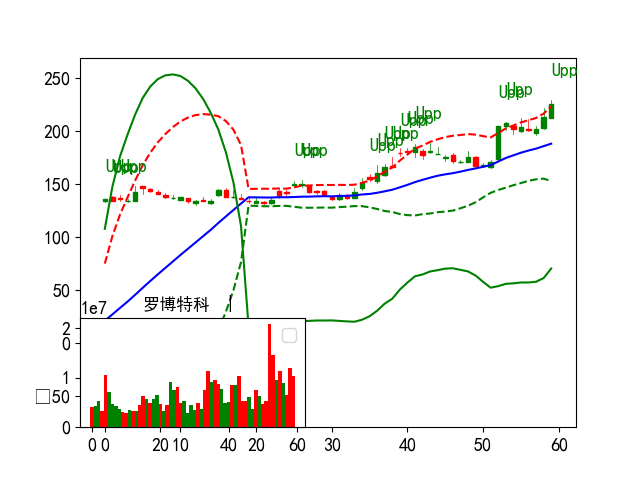

600739 1.27
xratio:0.04 ra_diff:1.27
code: 600739


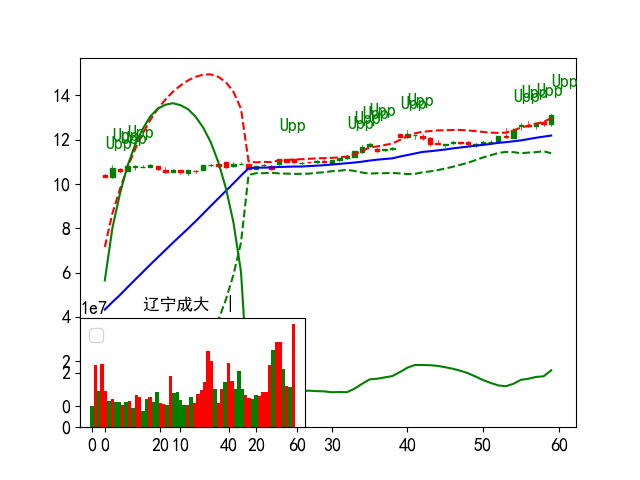

399006 1.35
xratio:10.08 ra_diff:1.35
code: 399006


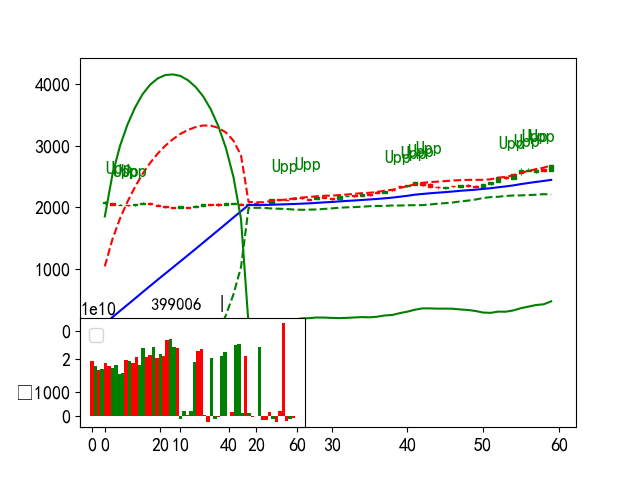

603626 1.96
xratio:0.04 ra_diff:1.96
code: 603626


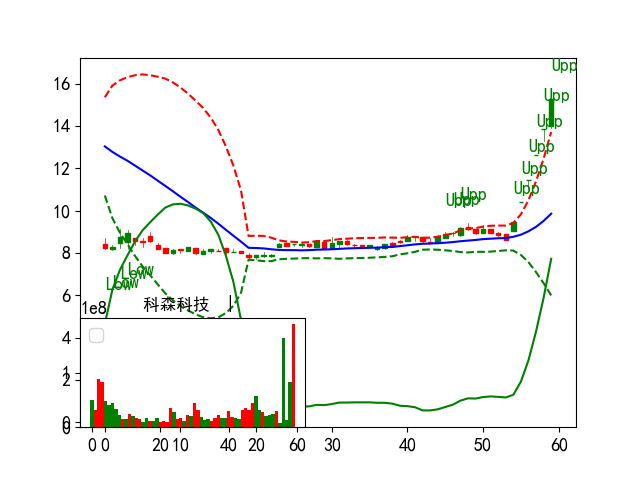

600061 1.24
xratio:0.02 ra_diff:1.24
code: 600061


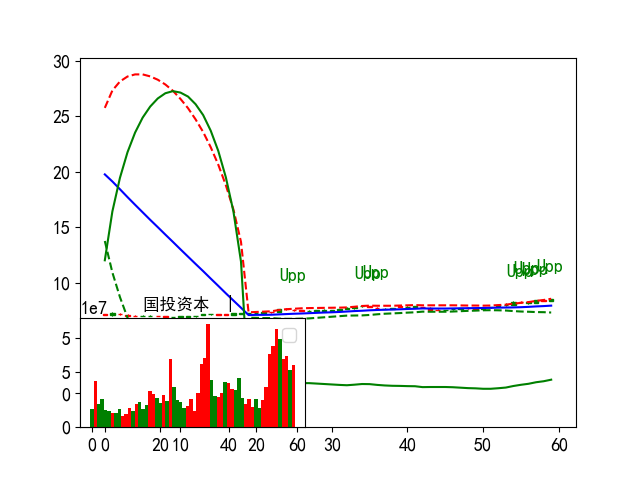

002518 1.65
xratio:0.12 ra_diff:1.65
code: 002518


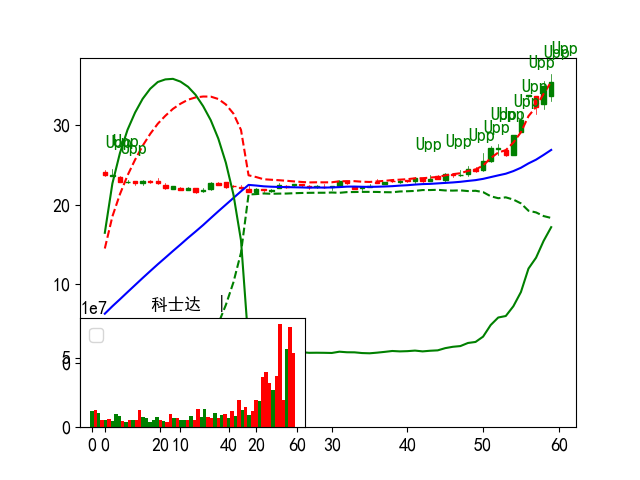

600183 1.87
xratio:0.36 ra_diff:1.87
code: 600183


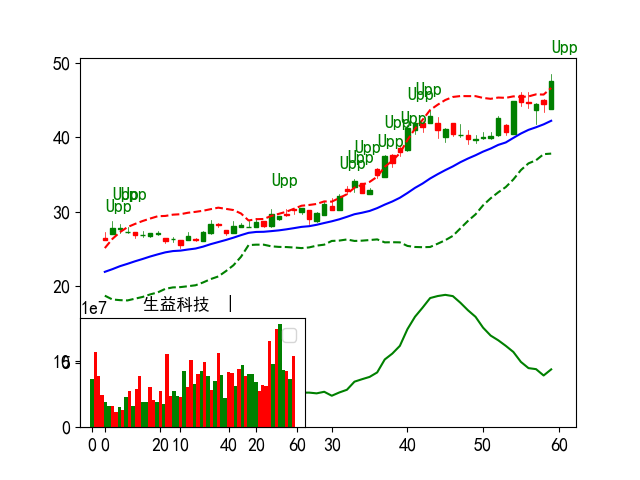

002625 1.29
xratio:0.07 ra_diff:1.29
code: 002625


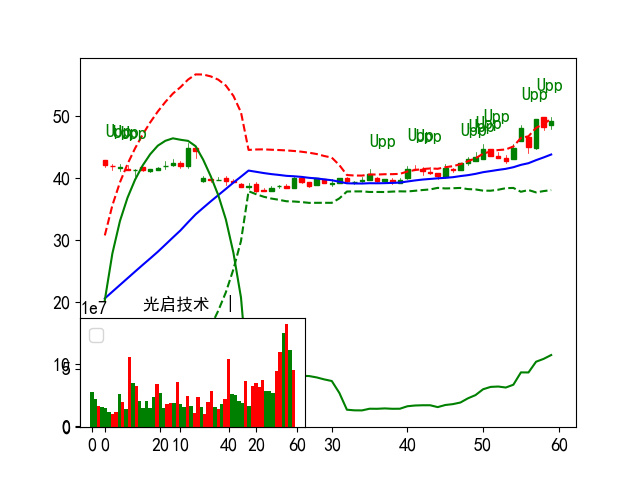

603848 1.73
xratio:0.13 ra_diff:1.73
code: 603848


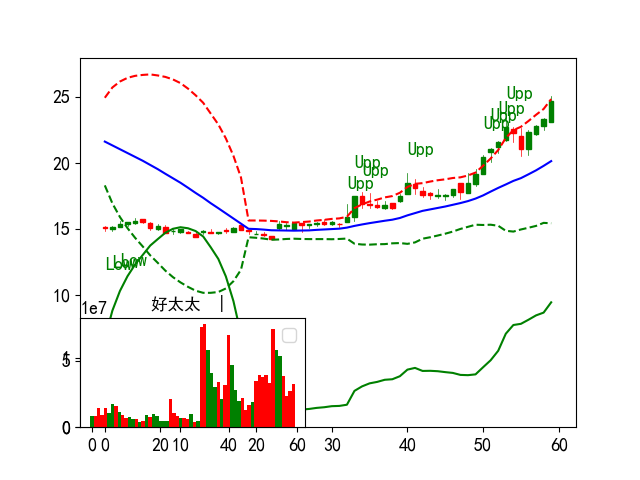

600243 1.73
xratio:0.02 ra_diff:1.73
code: 600243


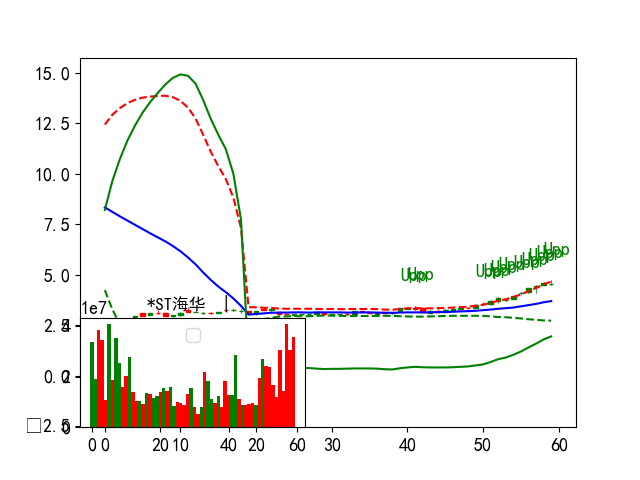

300165 1.57
xratio:0.03 ra_diff:1.57
code: 300165


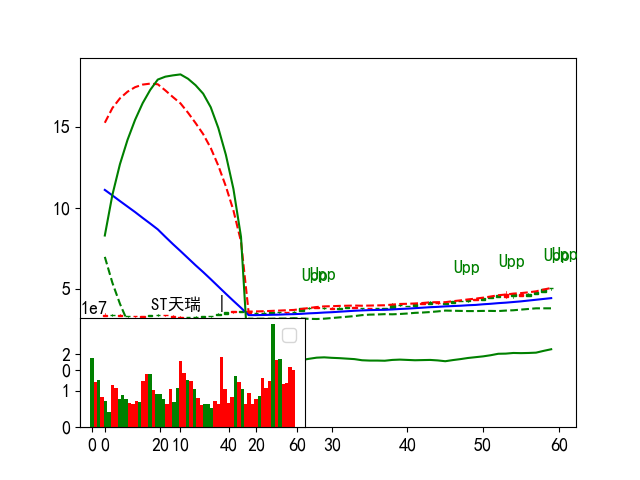

601288 1.33
xratio:0.03 ra_diff:1.33
code: 601288


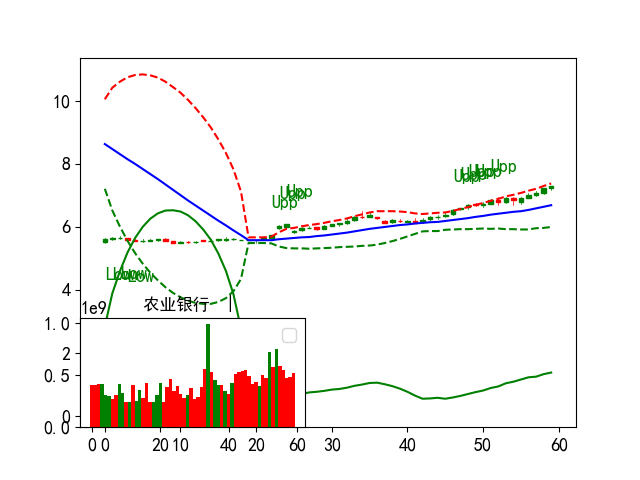

002657 2.45
xratio:0.32 ra_diff:2.45
code: 002657


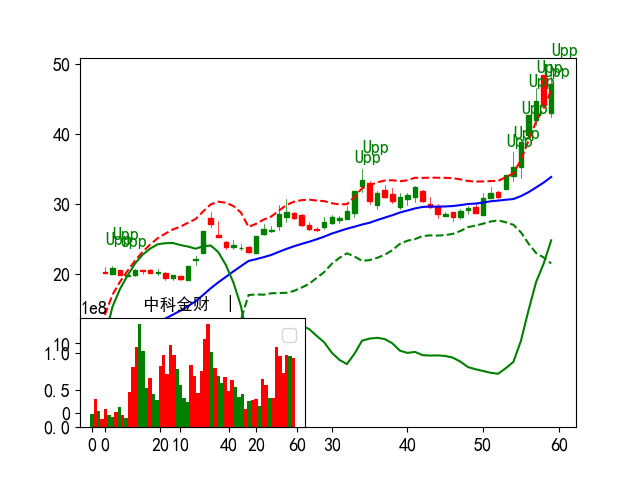

003019 1.49
xratio:0.09 ra_diff:1.49
code: 003019


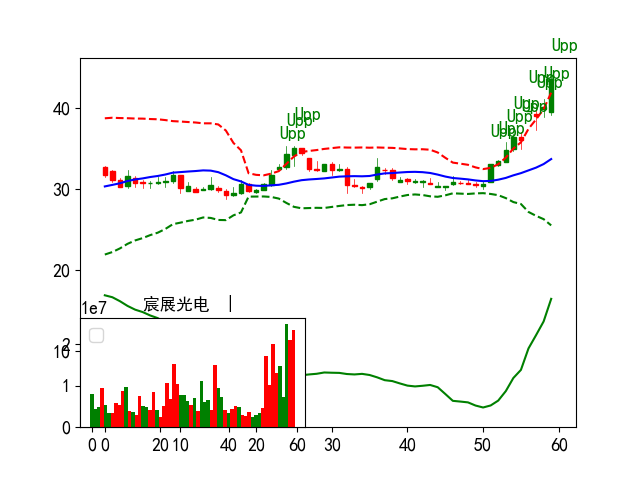

000063 1.5
xratio:0.11 ra_diff:1.5
code: 000063


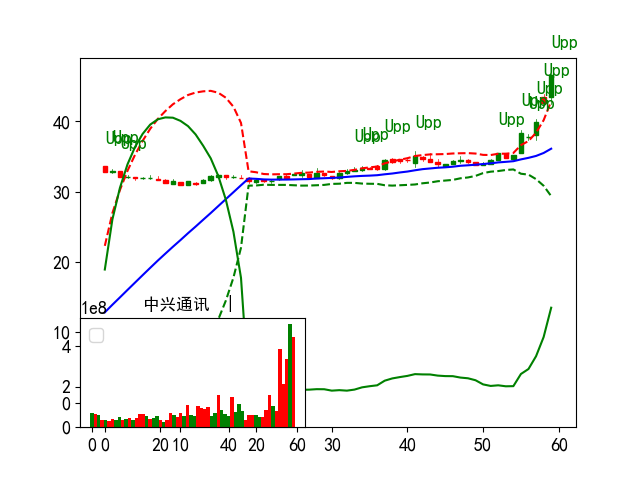

600536 1.28
xratio:0.1 ra_diff:1.28
code: 600536


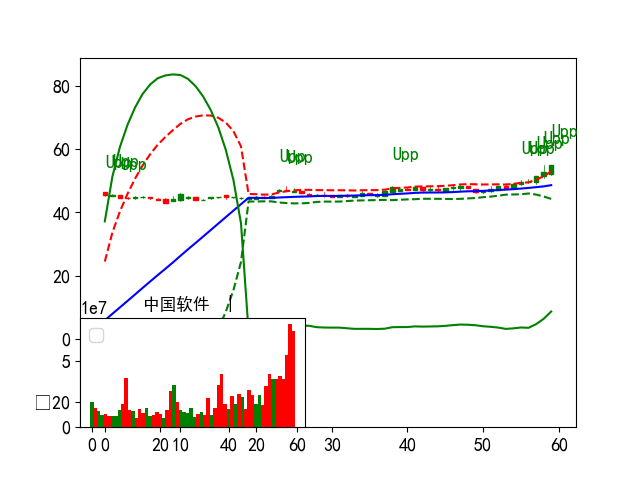

002241 1.43
xratio:0.08 ra_diff:1.43
code: 002241


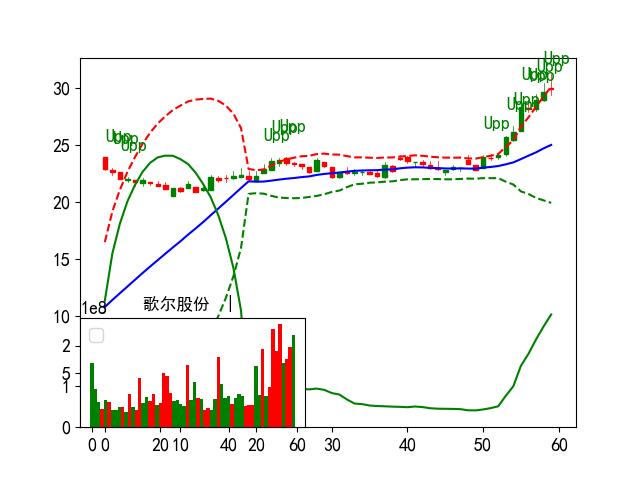

600549 1.42
xratio:0.1 ra_diff:1.42
code: 600549


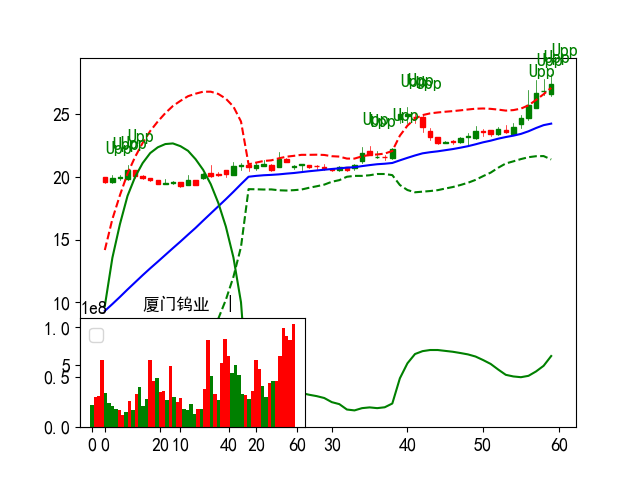

In [216]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:20]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:112
605028 1.76
xratio:0.11 ra_diff:1.76
code: 605028


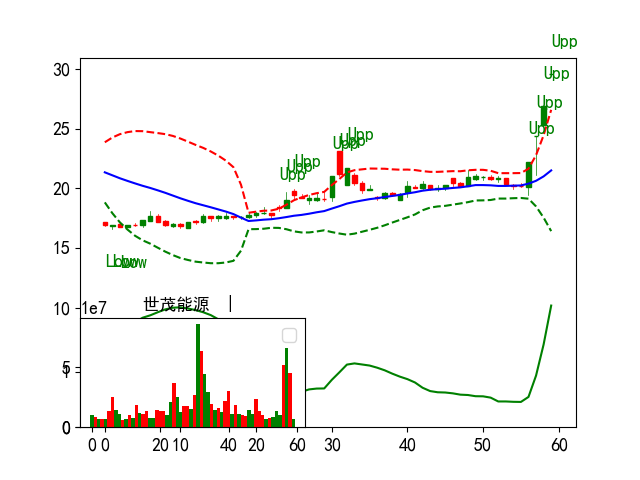

002190 1.81
xratio:0.07 ra_diff:1.81
code: 002190


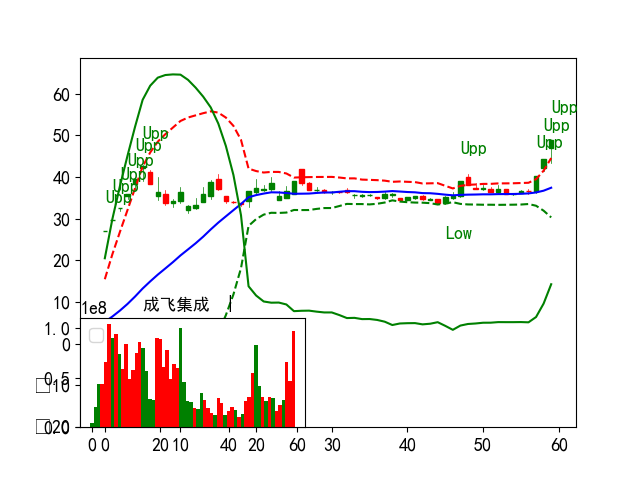

000063 1.5
xratio:0.11 ra_diff:1.5
code: 000063


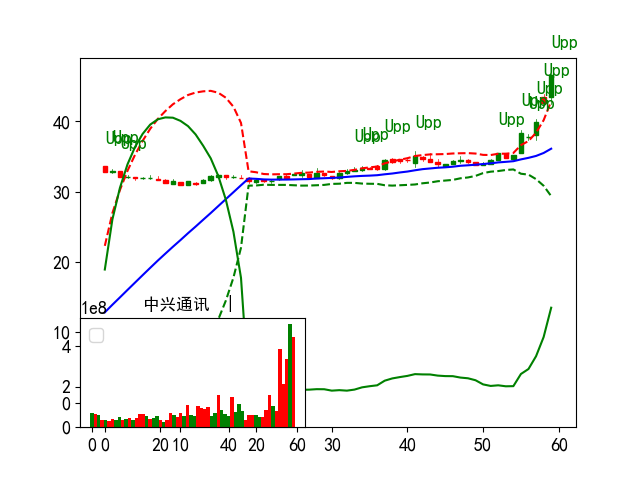

301259 1.35
xratio:-0.05 ra_diff:1.35
code: 301259


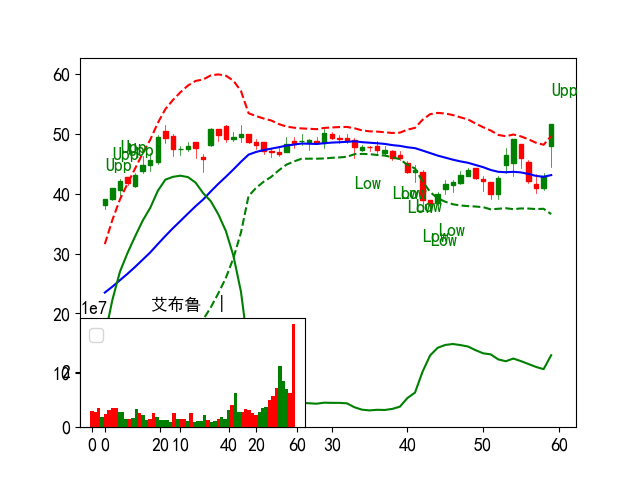

603986 1.34
xratio:0.09 ra_diff:1.34
code: 603986


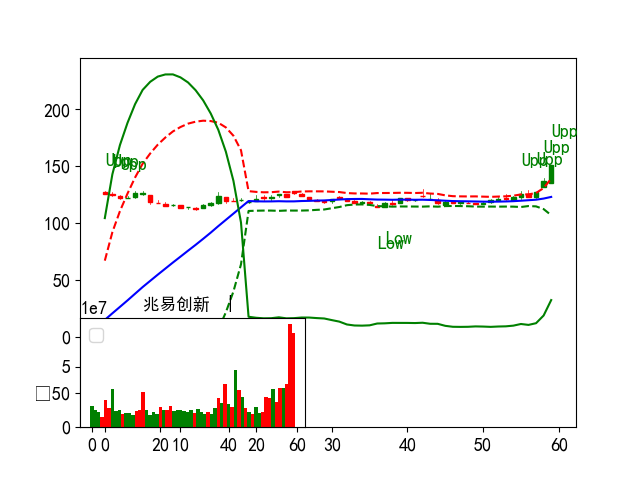

300113 1.49
xratio:0.07 ra_diff:1.49
code: 300113


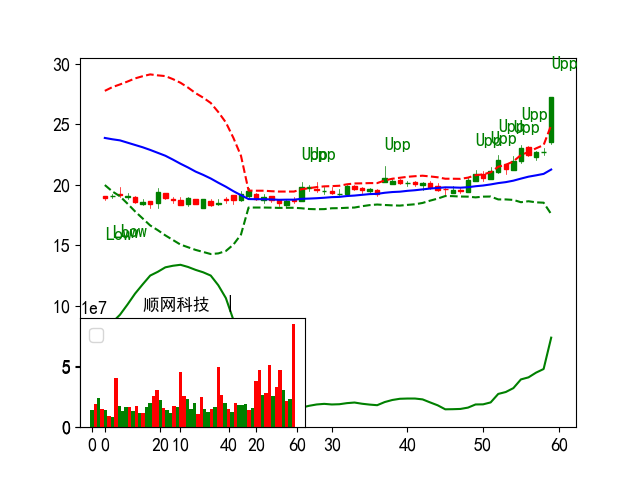

300767 2.52
xratio:0.17 ra_diff:2.52
code: 300767


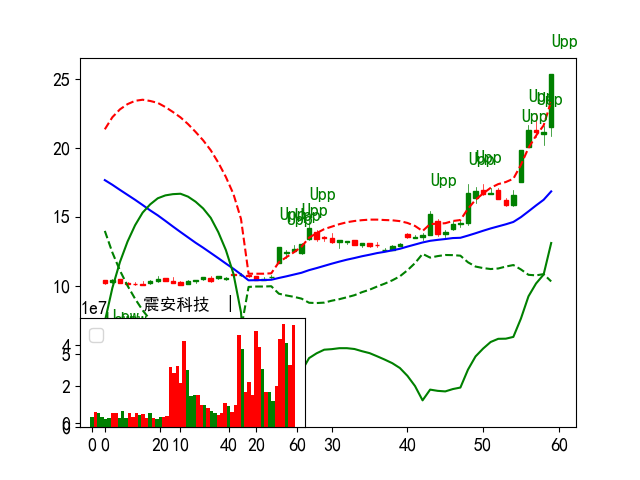

301108 1.37
xratio:-0.14 ra_diff:1.37
code: 301108


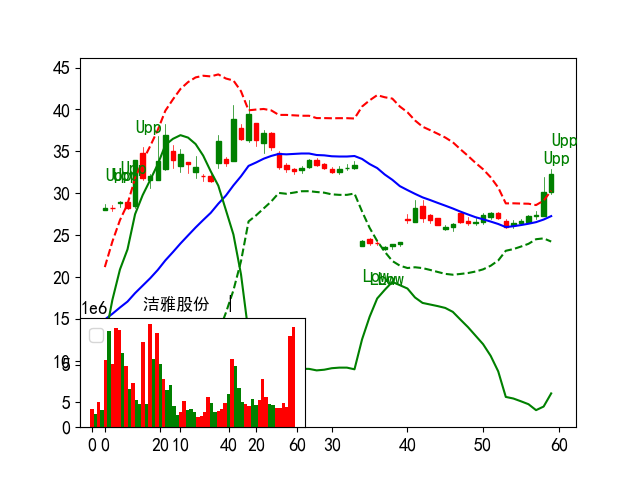

300730 2.0
xratio:0.11 ra_diff:2.0
code: 300730


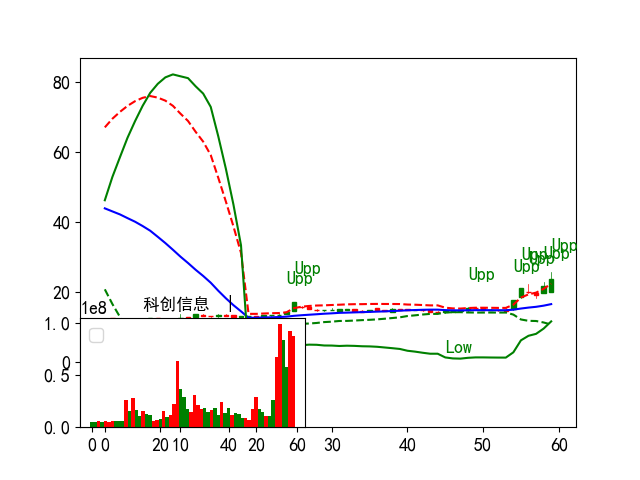

600490 1.34
xratio:0.01 ra_diff:1.34
code: 600490


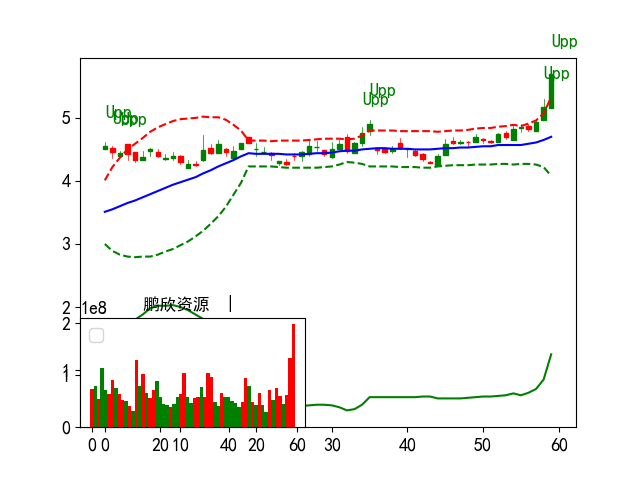

In [217]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [218]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:73
Count:73 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                           
605028  世茂能源      3 2025-08-22  10.01     1.76    0.24   8.58  10.17   29.55   
002190  成飞集成      3 2025-08-22  10.01     1.81    0.31  11.40  14.24   48.78   
000063  中兴通讯      2 2025-08-22   9.40     1.50    0.31  12.56  13.50   46.56   
301259   艾布鲁      1 2025-08-22  19.96     1.35    0.03   9.46  13.03   51.62   
603986  兆易创新      3 2025-08-22  10.04     1.34    0.67  32.94  32.15  150.88   

        volsum5d  ...  ma250  nclose    llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                          
605028     290.3  ...  15.58   29.55   29.55  -85.34  -31.71   28.24  405.04   
002190     280.3  ...  19.38   48.06   43.34  108.03  -29.33  136.85   23.57   
000063     441.2  ...  15.30   45.22   42.50  -13.11   51.09   60.41  -45.41   
301259     209.4  ...  43.06   48.75   44.50  204.14  -11.94  -16.35  -24.73   
603986     194.6  ...  41.09  144.12  135.12   -9.10  138.67   11.36   -1.62   

         vol5d  perc3d  perc5d  
code                            
605028  -25.94   33.11   46.07  
002190   41.19   33.06   35.50  
000063  388.18   23.14   32.20  
301259   58.27   22.73    4.94  
603986   55.32   22.42   22.79  

[5 rows x 24 columns]

df_mask250 cross_hmax_250:73
601799 1.08
xratio:-0.39 ra_diff:1.08
code: 601799


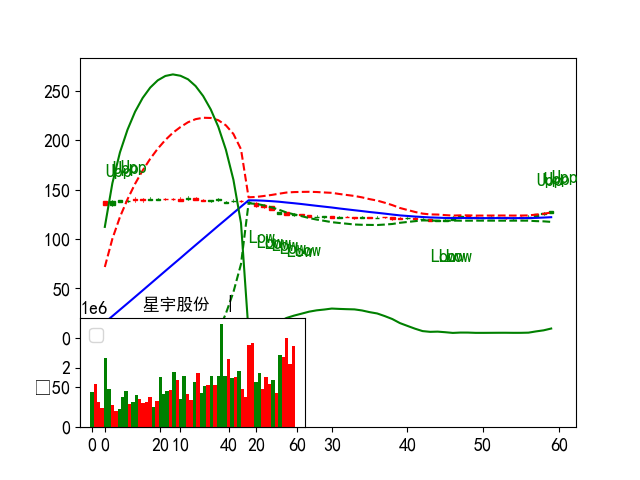

002152 1.27
xratio:0.04 ra_diff:1.27
code: 002152


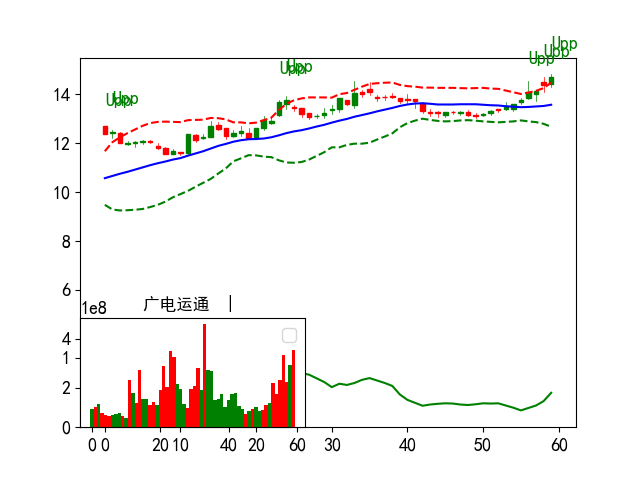

002415 1.13
xratio:0.02 ra_diff:1.13
code: 002415


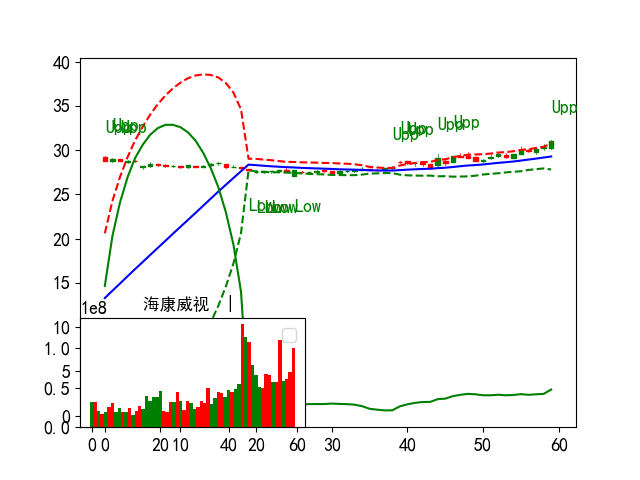

002001 1.13
xratio:0.01 ra_diff:1.13
code: 002001


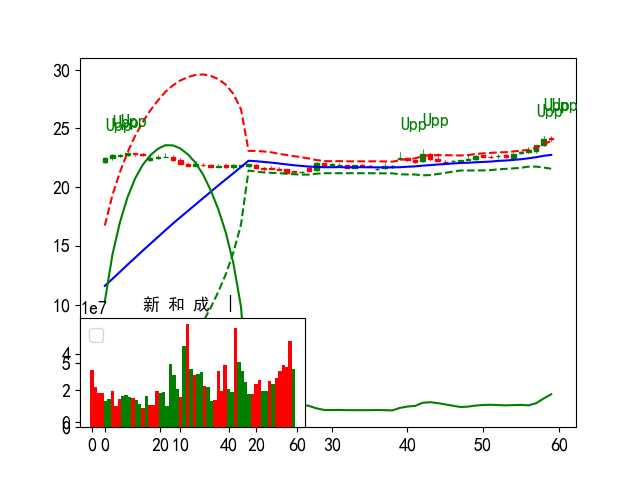

603199 1.06
xratio:-0.03 ra_diff:1.06
code: 603199


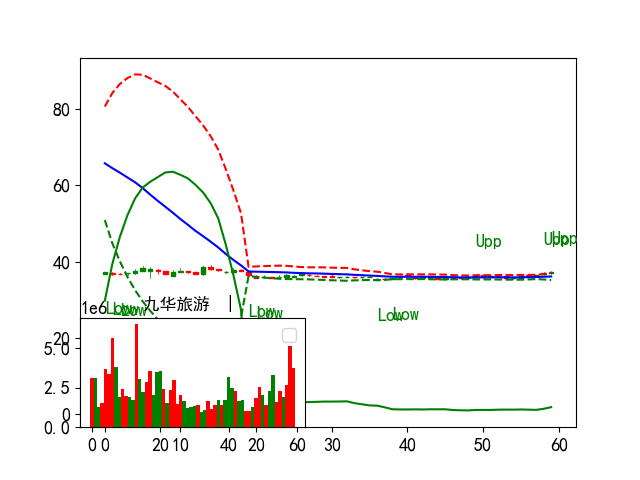

399001 1.21
xratio:30.74 ra_diff:1.21
code: 399001


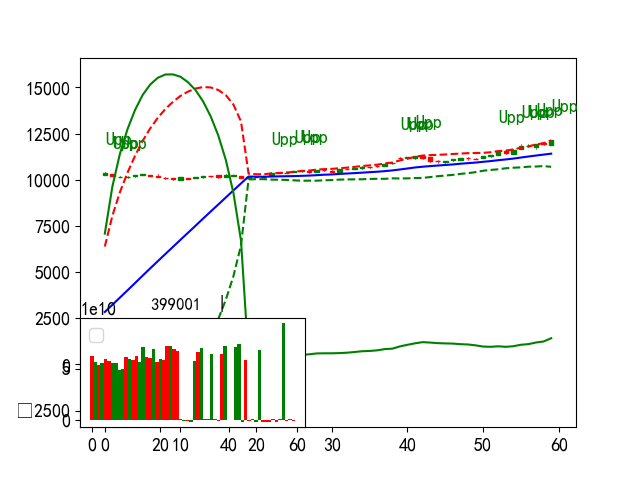

002236 1.23
xratio:0.04 ra_diff:1.23
code: 002236


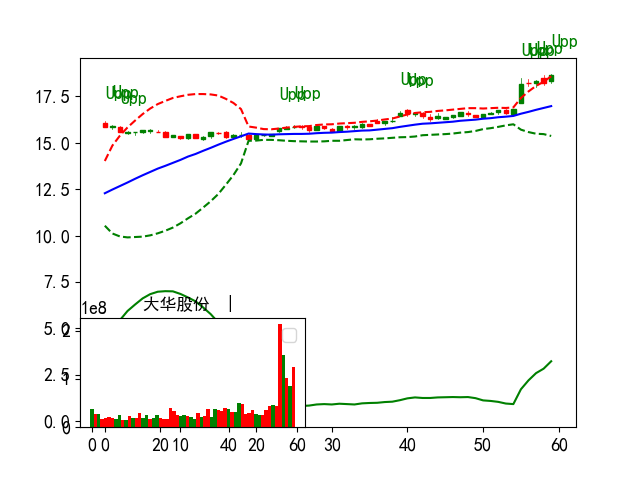

603220 1.12
xratio:-0.0 ra_diff:1.12
code: 603220


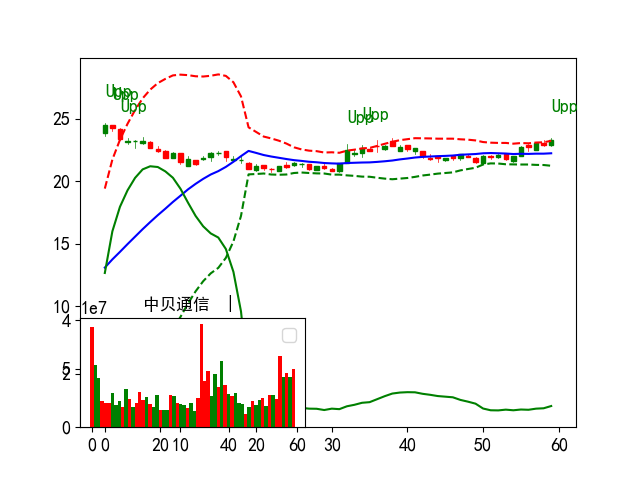

000021 1.26
xratio:0.04 ra_diff:1.26
code: 000021


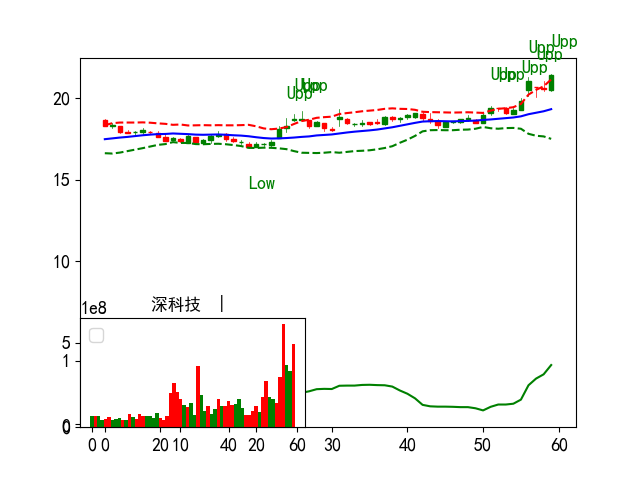

603000 1.12
xratio:0.02 ra_diff:1.12
code: 603000


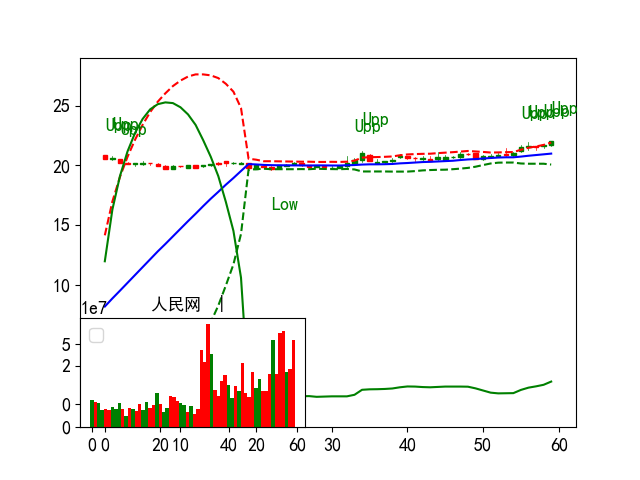

In [219]:
print("df_mask250 cross_hmax_250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [220]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [221]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [222]:
top_temp.shape
top_temp.index

(1203, 35)

Index(['688798', '603757', '300409', '688003', '000811', '301018', '301095',
       '301128', '002017', '301369',
       ...
       '300657', '600250', '600189', '301536', '002605', '002595', '301398',
       '688401', '002572', '688048'],
      dtype='object', name='code', length=1203)

## plt.close('all')

In [223]:
# plt.close('all')

# 写入060